In [1]:
%matplotlib inline
from netCDF4 import Dataset
from pylab import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
# from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams.update({'font.size': 20})

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
cmap = ListedColormap(sns.color_palette("coolwarm", 9).as_hex())
sns.reset_orig()

matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.facecolor'] = '#F8F8FF'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.axisbelow'] = True

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 1.5
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1.

In [2]:
print ('test')
def martians_year(ls, data):
    #### only looking at "second year"
    idx = np.where(ls==360)[0]
    if idx[0] != 0 and idx.size > 1:
        idx0 = idx[0]
        idx1 = idx[1]
        return data[idx0:idx1]
    elif idx[0] != 0 and idx.size == 1:
        idx1 = idx[0]
        return data[:idx1]
    elif idx[0] == 0:
        idx1 = idx[1]
        idx2 = idx[2]
        return data[idx1:idx2]

def martians_month(ls, data):
    temp = []
    for i in np.arange(0, 12):
        idx = np.where((ls>i*30)&(ls<(i+1)*30))[0]
        temp.append(data[idx].mean(axis=0))
    temp = np.array(temp)
    return temp

def zonal_plt_monthly(ydata, ls, data, title, level=12, norm=False, cmap=None):
    cmap=cmap or "viridis"
    from matplotlib.colors import SymLogNorm
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14,12))
    for i, ax in enumerate(axes.flat):
        y = ydata[i][6:]
        
        #press2 = zonal_p[i-1].mean(axis=1)
        lat = np.linspace(-90, 90, 36) 
        temp_press = np.linspace(1e-2, 900, ydata[i].shape[0])[6:]
        
        lat, temp_press = np.meshgrid(lat, temp_press)
        
        d = data[i][6:]

        if norm:
            im = ax.contourf(lat, y, d, levels=level, cmap=cmap, norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
            if not np.isnan(d).any():
                ax.contour(lat, y, d, levels=level, linewidths=0.5, colors='k', norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
                
            ax.xaxis.set_minor_locator(AutoMinorLocator(4))
        else: 
            im = ax.contourf(lat, y, d, level, cmap=cmap, extend='both')
            for c in im.collections:
                c.set_edgecolor("face")
#             if not np.isnan(d).any():
#                 ax.contour(lat, y, d, level, linewidths=0.5, colors='k', extend='both')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.set_title(r'{} LS {}-{}'.format((title), (i)*30, (i+1)*30))
        if i in [0,4,8]: ax.set_ylabel('Pressure [Pa]')
        if i in [8,9,10,11]: ax.set_xlabel('Latitude [$^\circ$]')
        ax.set_yscale('log')
        ax.set_ylim([900, 1e-2])
        ax.set_xlim([-95, 95])
        ax.grid(True, which='both')
        
#        print ('Saving 1st cool shit')
    fig.tight_layout()
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, orientation='horizontal', pad=0.05)
#     plt.savefig(pdFigures, format='pdf', bbox_inches='tight', dpi=400)

test


(6401, 52, 36)
processing done!
(52, 36)


(900, 0.01)

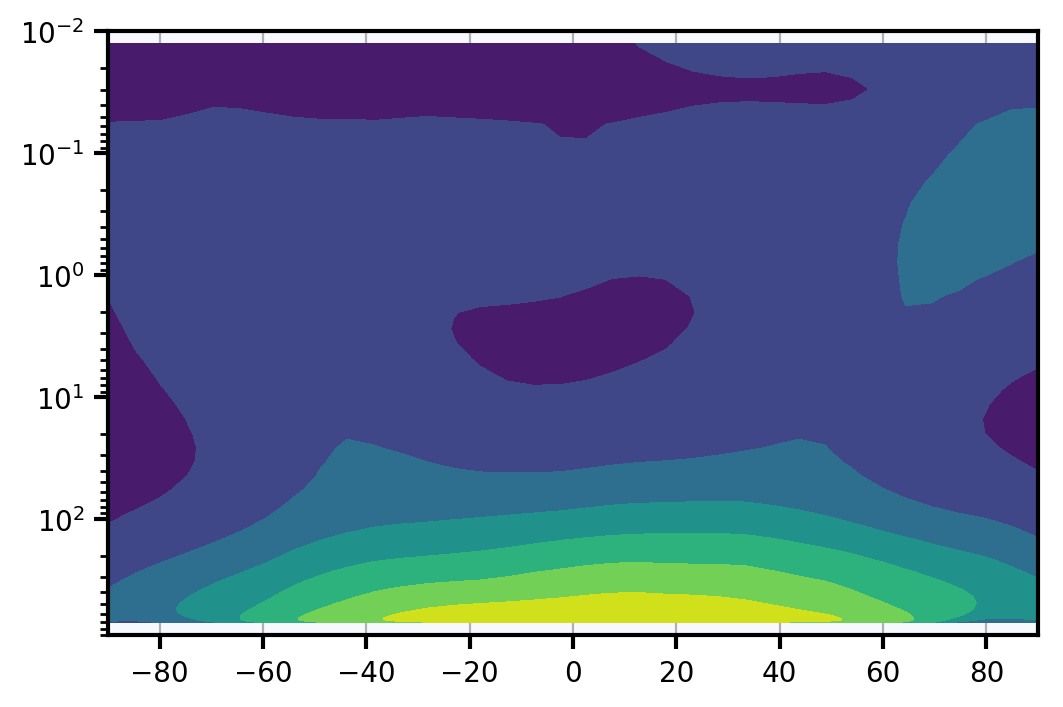

In [3]:
dataname = './r14p1dustL45'
filedir = dataname+'_full_TP.nc'

data = Dataset(filedir, 'r')
ls = data.variables['LS'][:]
tfull = data.variables['T'][:]
pfull = data.variables['P'][:]
print (pfull.shape)

tfull = martians_year(ls, tfull) [:5280]
pfull = martians_year(ls, pfull) [:5280]

tfull = tfull.reshape((12, 440, 52, 36, 72))
pfull = pfull.reshape((12, 440, 52, 36))
p = pfull.mean(axis=1)
del pfull

print ('processing done!')
print (tfull[0].mean(axis=3).mean(axis=0).shape)

plt.contourf(np.linspace(-90,90,36), p[0].mean(axis=1), tfull[0].mean(axis=3).mean(axis=0))
plt.yscale('log')
plt.ylim([900,1e-2])

In [ ]:
tmpPress = np.linspace(0,1,52)
lat = np.linspace(-90,90,36)
lat, press = np.meshgrid(lat, tmpPress)

frequency = [0,1,2,3, 0,2,1,1, 0,2,2,1,1]
zwave =     [0,1,2,3, 1,1,0,2, 2,0,4,-1,3]
varlist = ['M0_00', 'M0_11', 'M0_22', 'M0_33', 'M1_01', 'M1_21', 'M1_10', 'M1_12', 'M2_02', 'M2_20', 'M2_24', 'M2_1-1', 'M2_13']

filtered_array = []
for j in (np.arange(len(frequency))):
    test_waven = zwave[j]
    test_freq = frequency[j]
    
    for i in np.arange(12):
        press = p[i]

        tst = tfull[i]# - tfull[6].mean(axis=0)
        Tfft = (np.fft.fftshift(np.fft.ifft2(tst, axes=[0,3]), axes=[0,3]))#(4*np.pi)

        # sigma and s
        freq = np.fft.fftshift(np.fft.fftfreq(440, 180/1440.))
        waven = np.fft.fftshift(np.fft.fftfreq(72, 5.))*360 

        # find indexes where waven and period is a certain period
        idx_waven = np.where(waven==test_waven)[0] # positive wavenuber
        idx_period = np.where(abs(freq-test_freq)<.01)[0][0]  # positive frequency

        # picking the right components
        filtered = Tfft[idx_period,:,:,:][:,:,idx_waven]
        amp = filtered[:,:,0]
        filtered_array.append(amp)
filtered_array  = np.array(filtered_array, np.complex64)
#amp1 = amp#.mean(axis=0)

plt.contourf(lat, press, amp)
plt.colorbar()
plt.yscale('log')
plt.ylim([900,1e-2])

In [11]:
reshaped_array = filtered_array.reshape((len(frequency), 12, 52, 36))
#dataset.close()

from netCDF4 import Dataset

def create3D_complVar(varnameList, units, data):   
    tmp = dataset.createVariable(varnameList[0], c64, (varnameList[1], varnameList[2], varnameList[3],))
    tmp.units = (units)
    
    dataTmp = np.empty((12,52,36), complex64)
    dataTmp['real'] = data.real
    dataTmp['imag'] = data.imag
    tmp[:] = dataTmp
    
    
def create3D_var(varnameList, units, data):   
    tmp = dataset.createVariable(varnameList[0], np.float32, (varnameList[1], varnameList[2], varnameList[3],))
    tmp.units = (units)
    
    tmp[:] = data
    
    
dataset = Dataset(dataname+'_fullfield_filtered.nc', 'w')

# create complex128 compound data type.
complex64 = np.dtype([("real",np.float32),("imag",np.float32)])
c64 = dataset.createCompoundType(complex64, "complex64")

month = dataset.createDimension('martian_months', 12)
pressure = dataset.createDimension('bottom_top', 52)
latitude = dataset.createDimension('south_north', 36)

months = dataset.createVariable('MONTH', np.int32, ('martian_months',))
latitudes = dataset.createVariable('LAT', np.float32, ('south_north',))

create3D_var(['P', 'martian_months', 'bottom_top', 'south_north'], 'Pa', p)
for i, var in enumerate(varlist):
    print(i)
    create3D_complVar([var, 'martian_months', 'bottom_top', 'south_north'], 'K', reshaped_array[i])
                                        
#amp = dataset.createVariable('M0_ZM', np.float32, ('martian_months', 'bottom_top', 'south_north',))

months.units = ('440_solar_days_avg')
latitudes.units = ('Degree')
latitudes[:] = np.linspace(-90,90,36)

dataset.close()

print ('done!')

0
1
2
3
4
5
6
7
8
done!


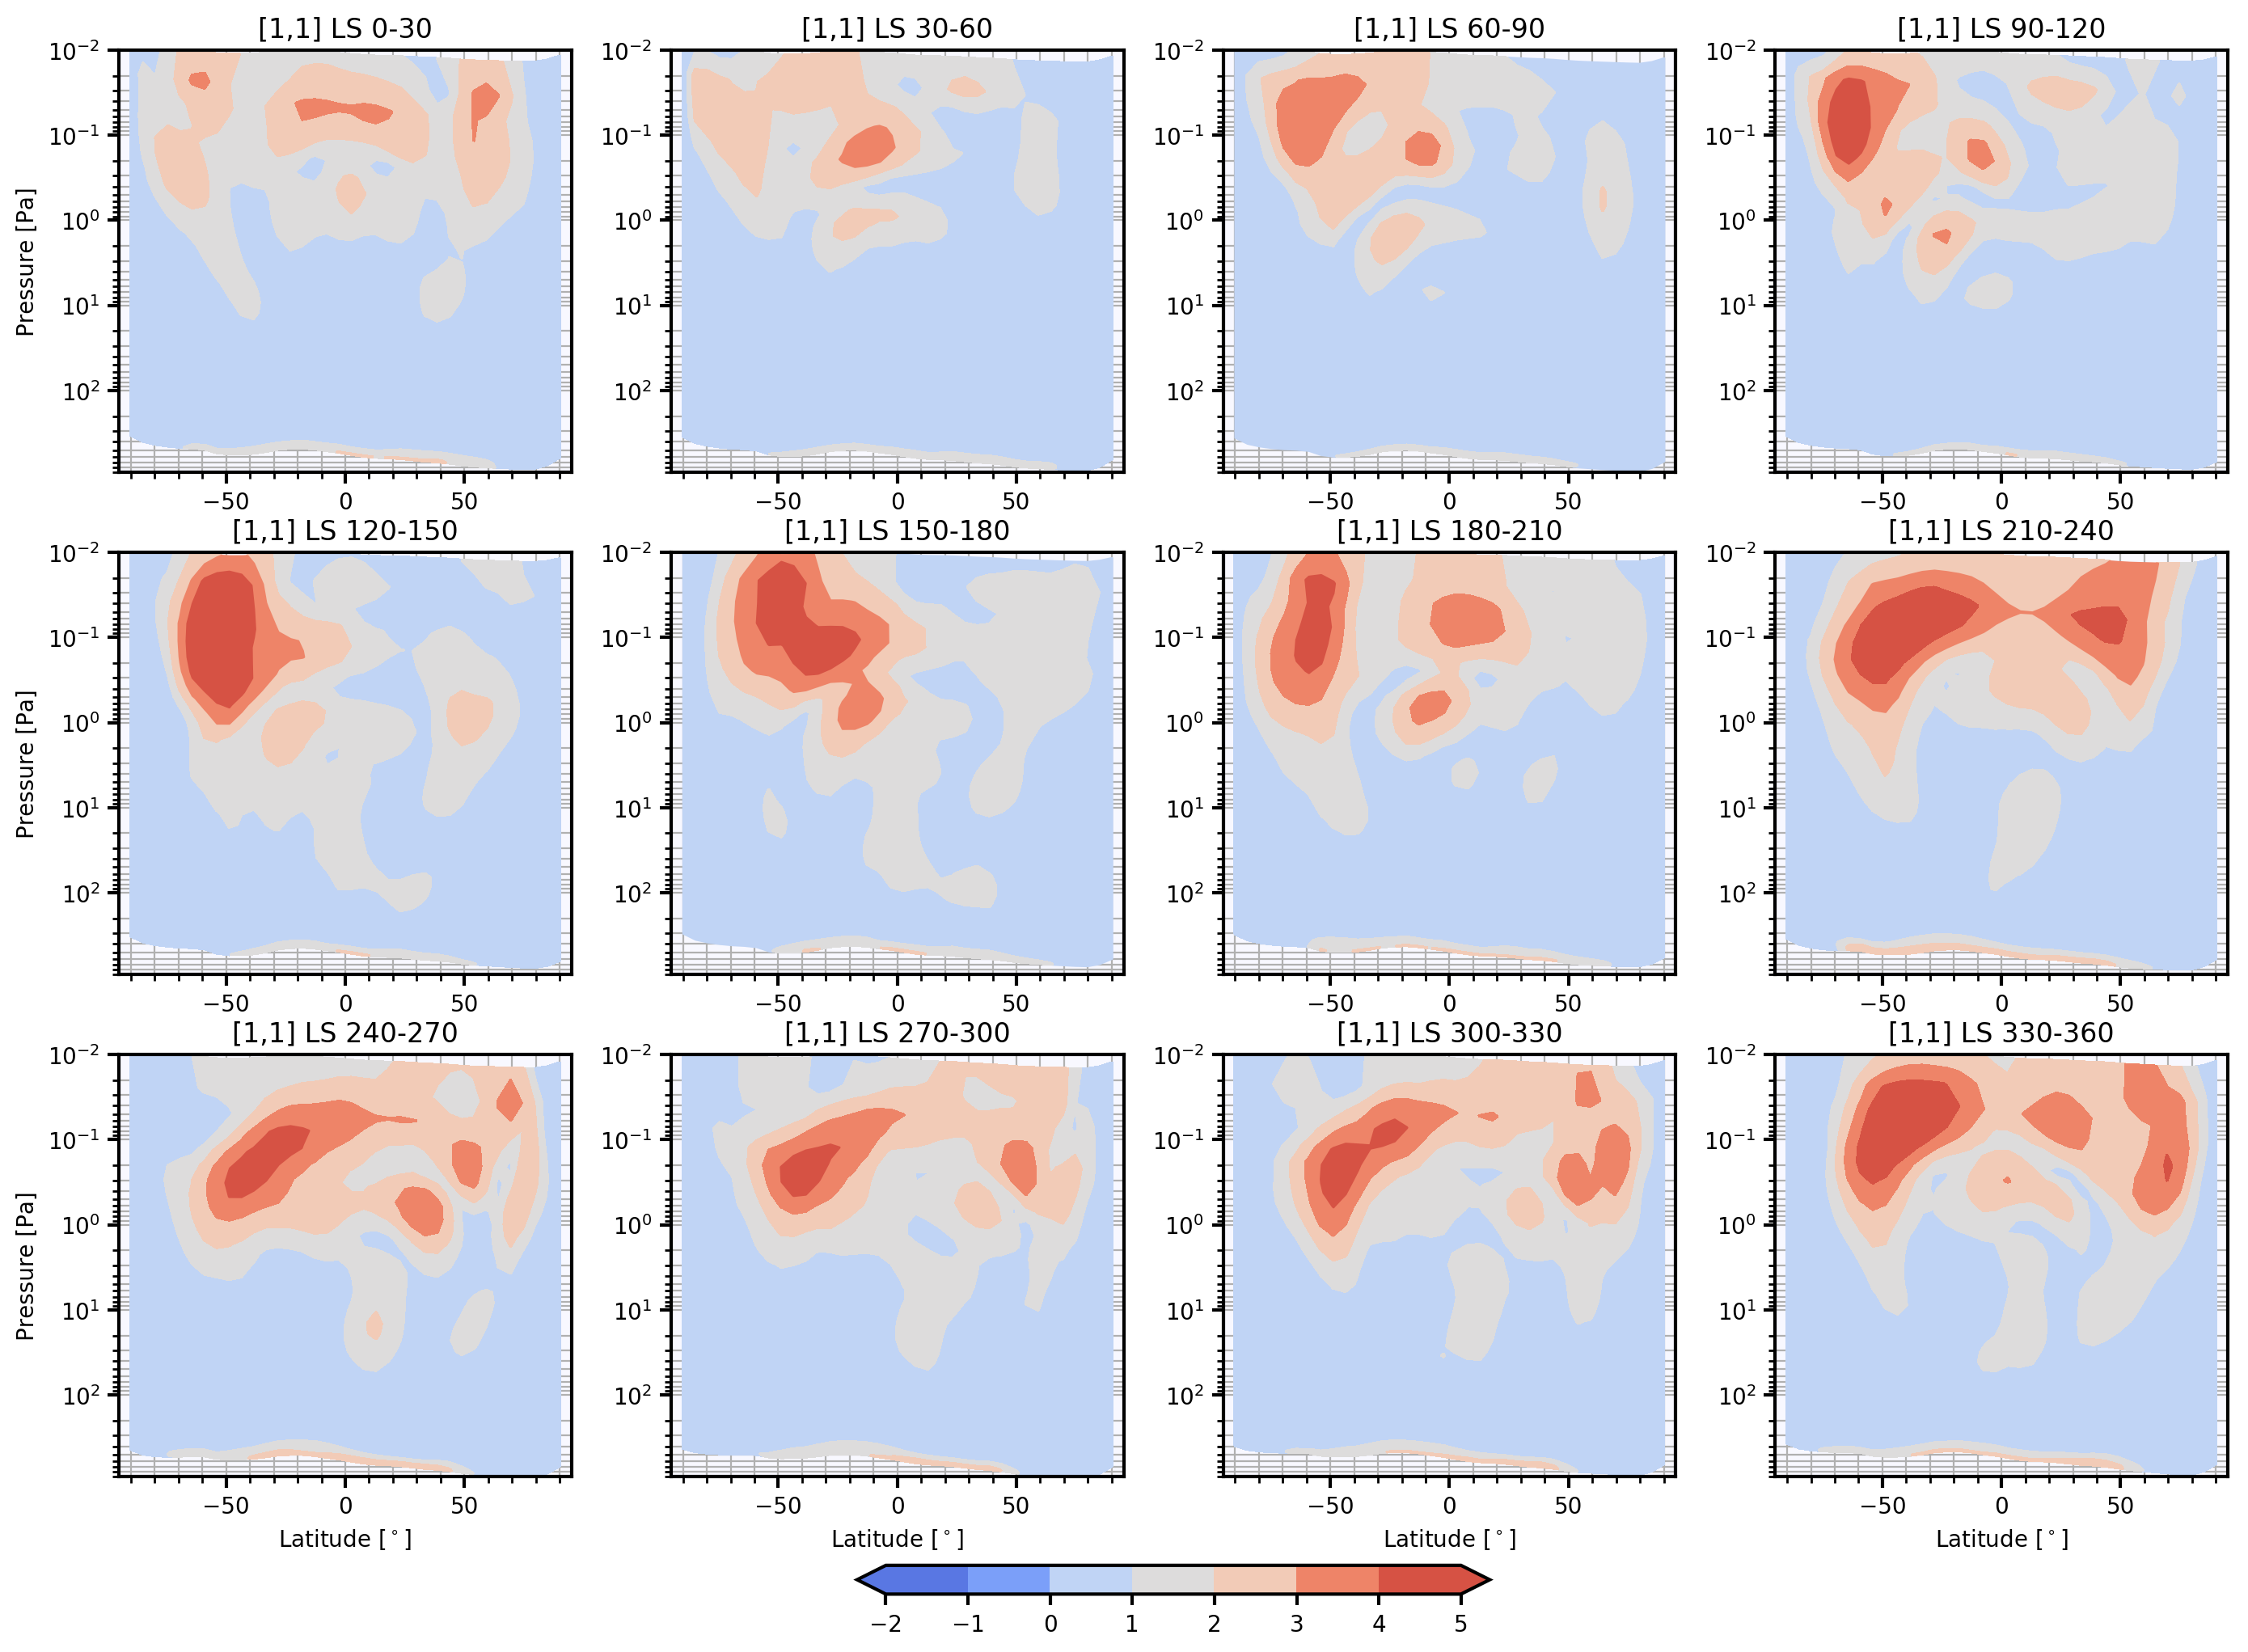

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

data = Dataset(dataname+'_fullfield_filtered.nc', mode='r')
M0_ZM = data.variables['M0_SEMI'][:]
# M0_DIUR = data.variables['M0_11'][:]
# M0_SEMI = data.variables['M0_22'][:]
# M0_TER = data.variables['M0_33'][:]
M1_10 = data.variables['M1_10'][:]
M1_01 = data.variables['M1_01'][:]

M2_02 = data.variables['M2_02'][:]
M2_20 = data.variables['M2_20'][:]
M2_1_1 = data.variables['M2_1-1'][:]

pressure = data.variables['P'][:]
ls = np.linspace(-90,90.36)
data.close()

zonal_plt_monthly(pressure, ls, np.sqrt(M0_ZM['real']**2 + M0_ZM['imag']**2), '[2,2]', np.linspace(-2,5,8), False, cmap)

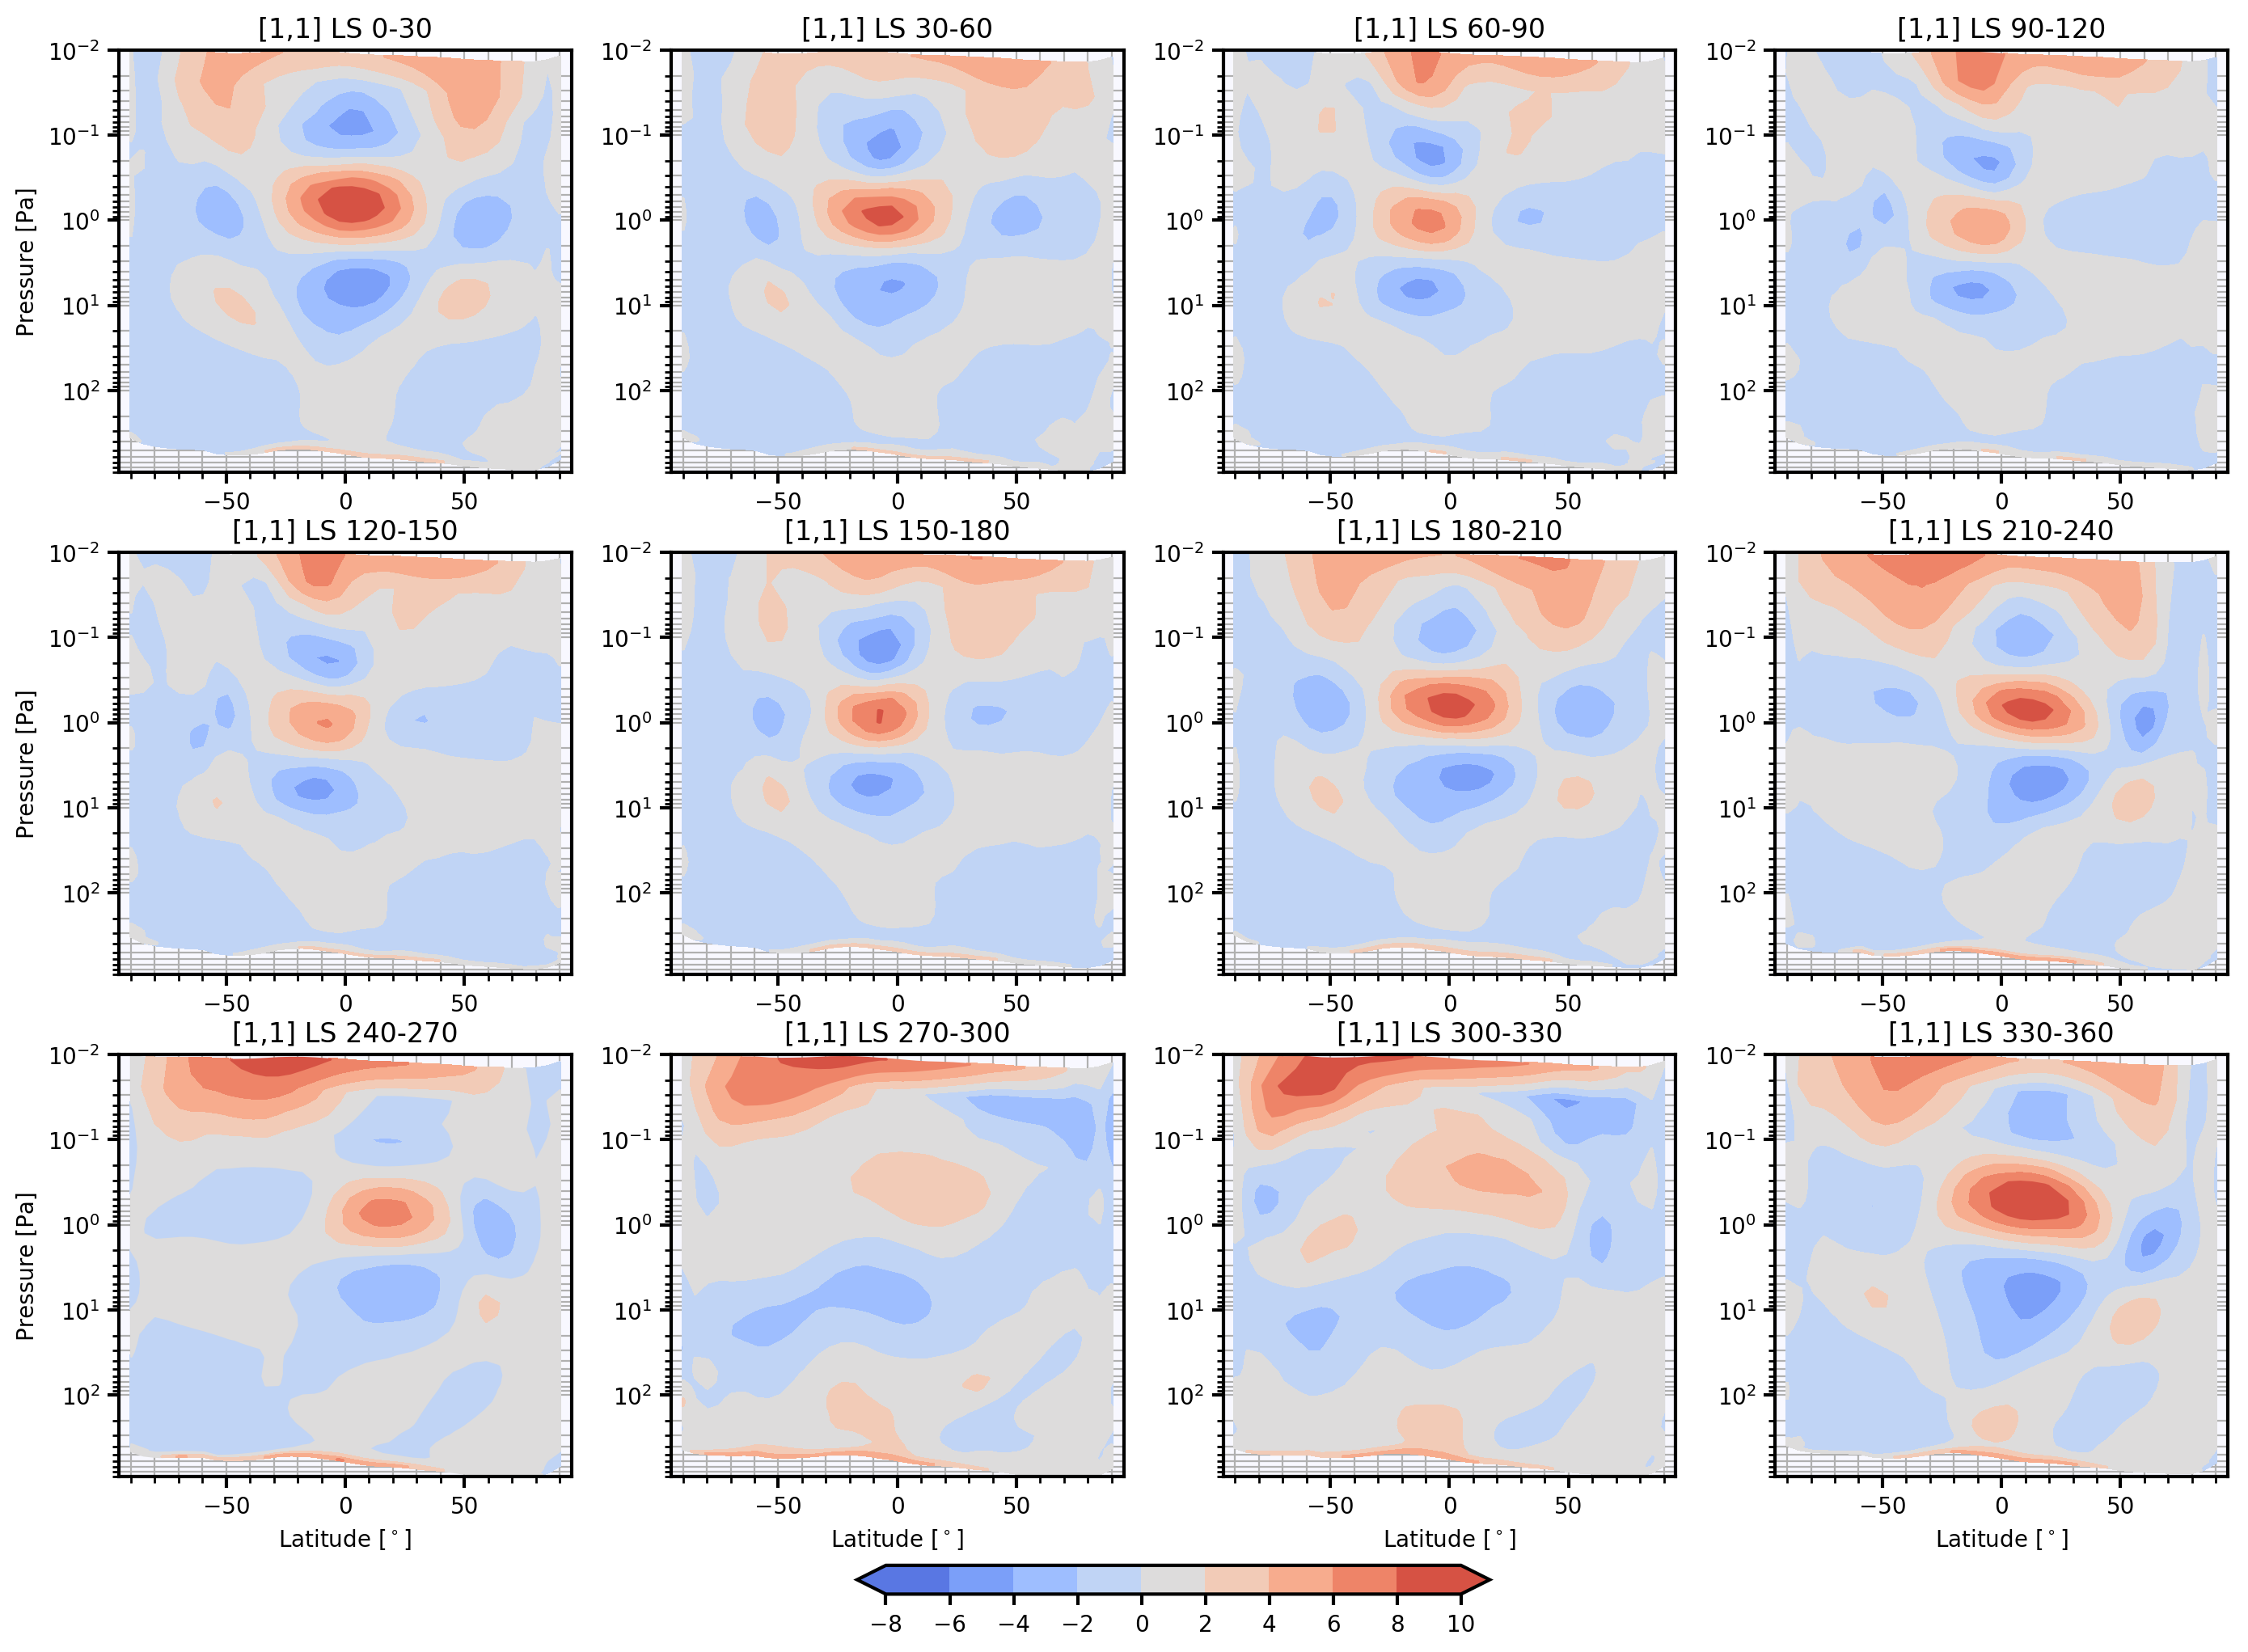

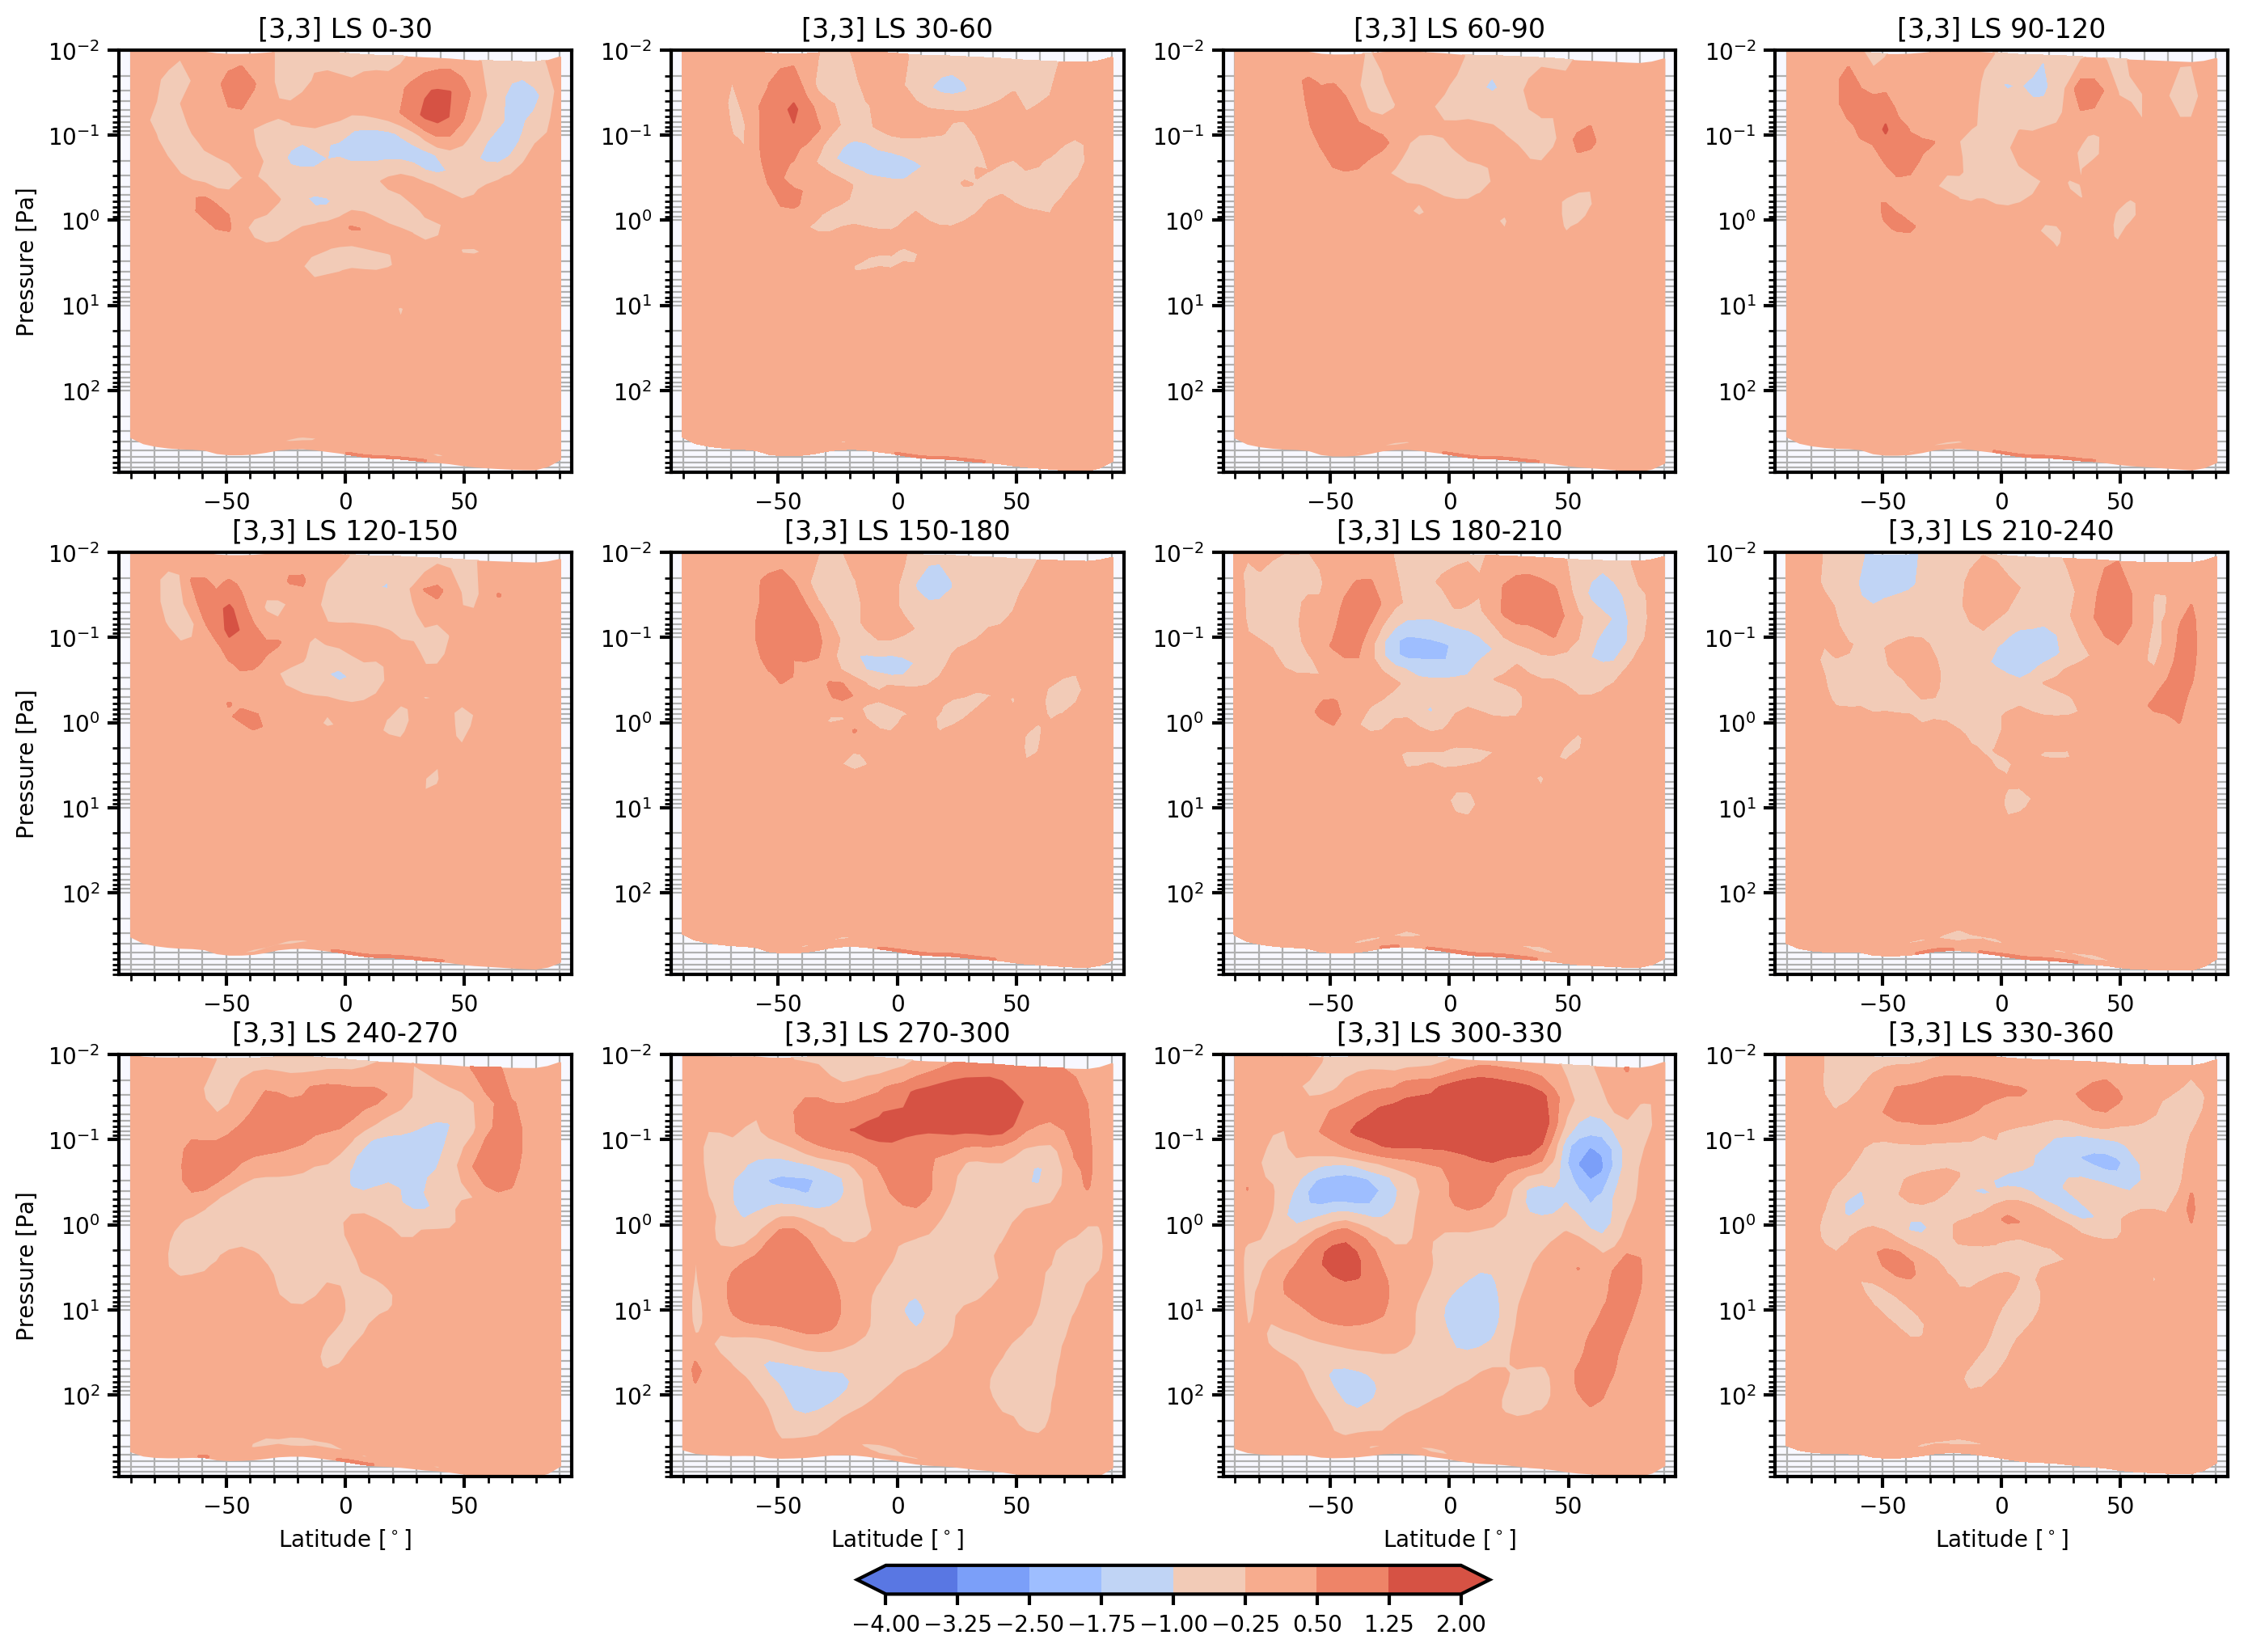

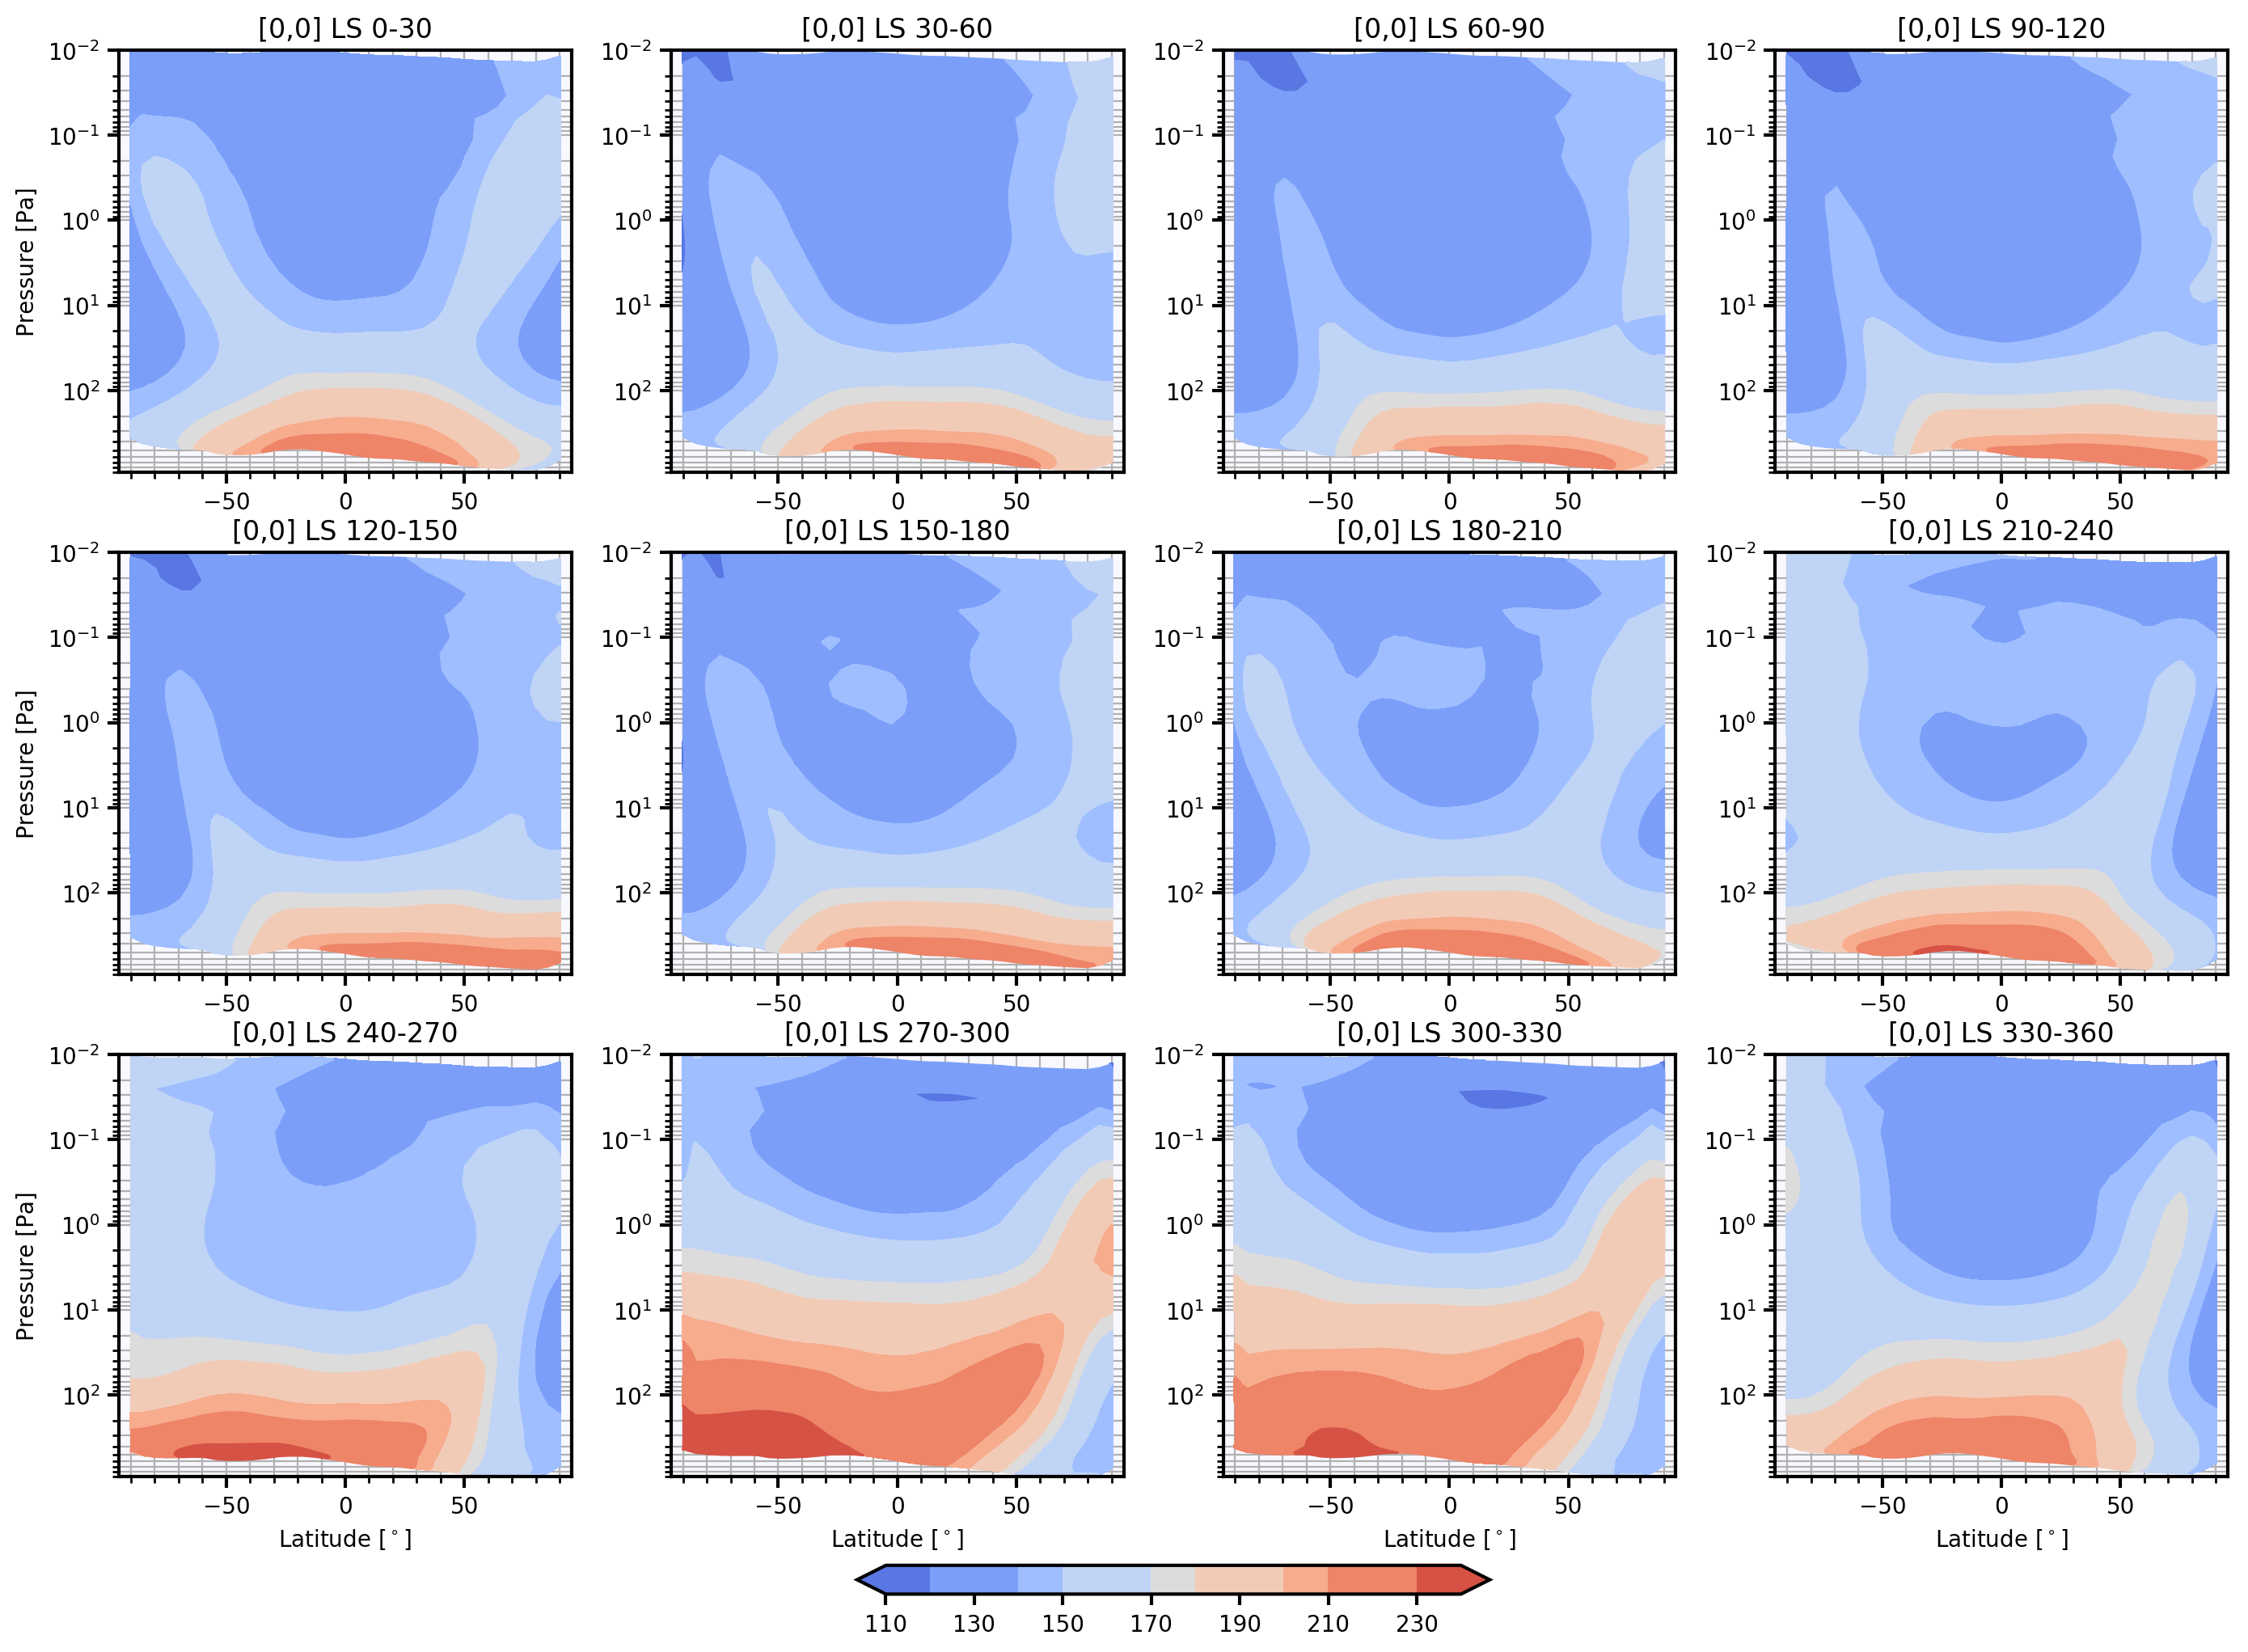

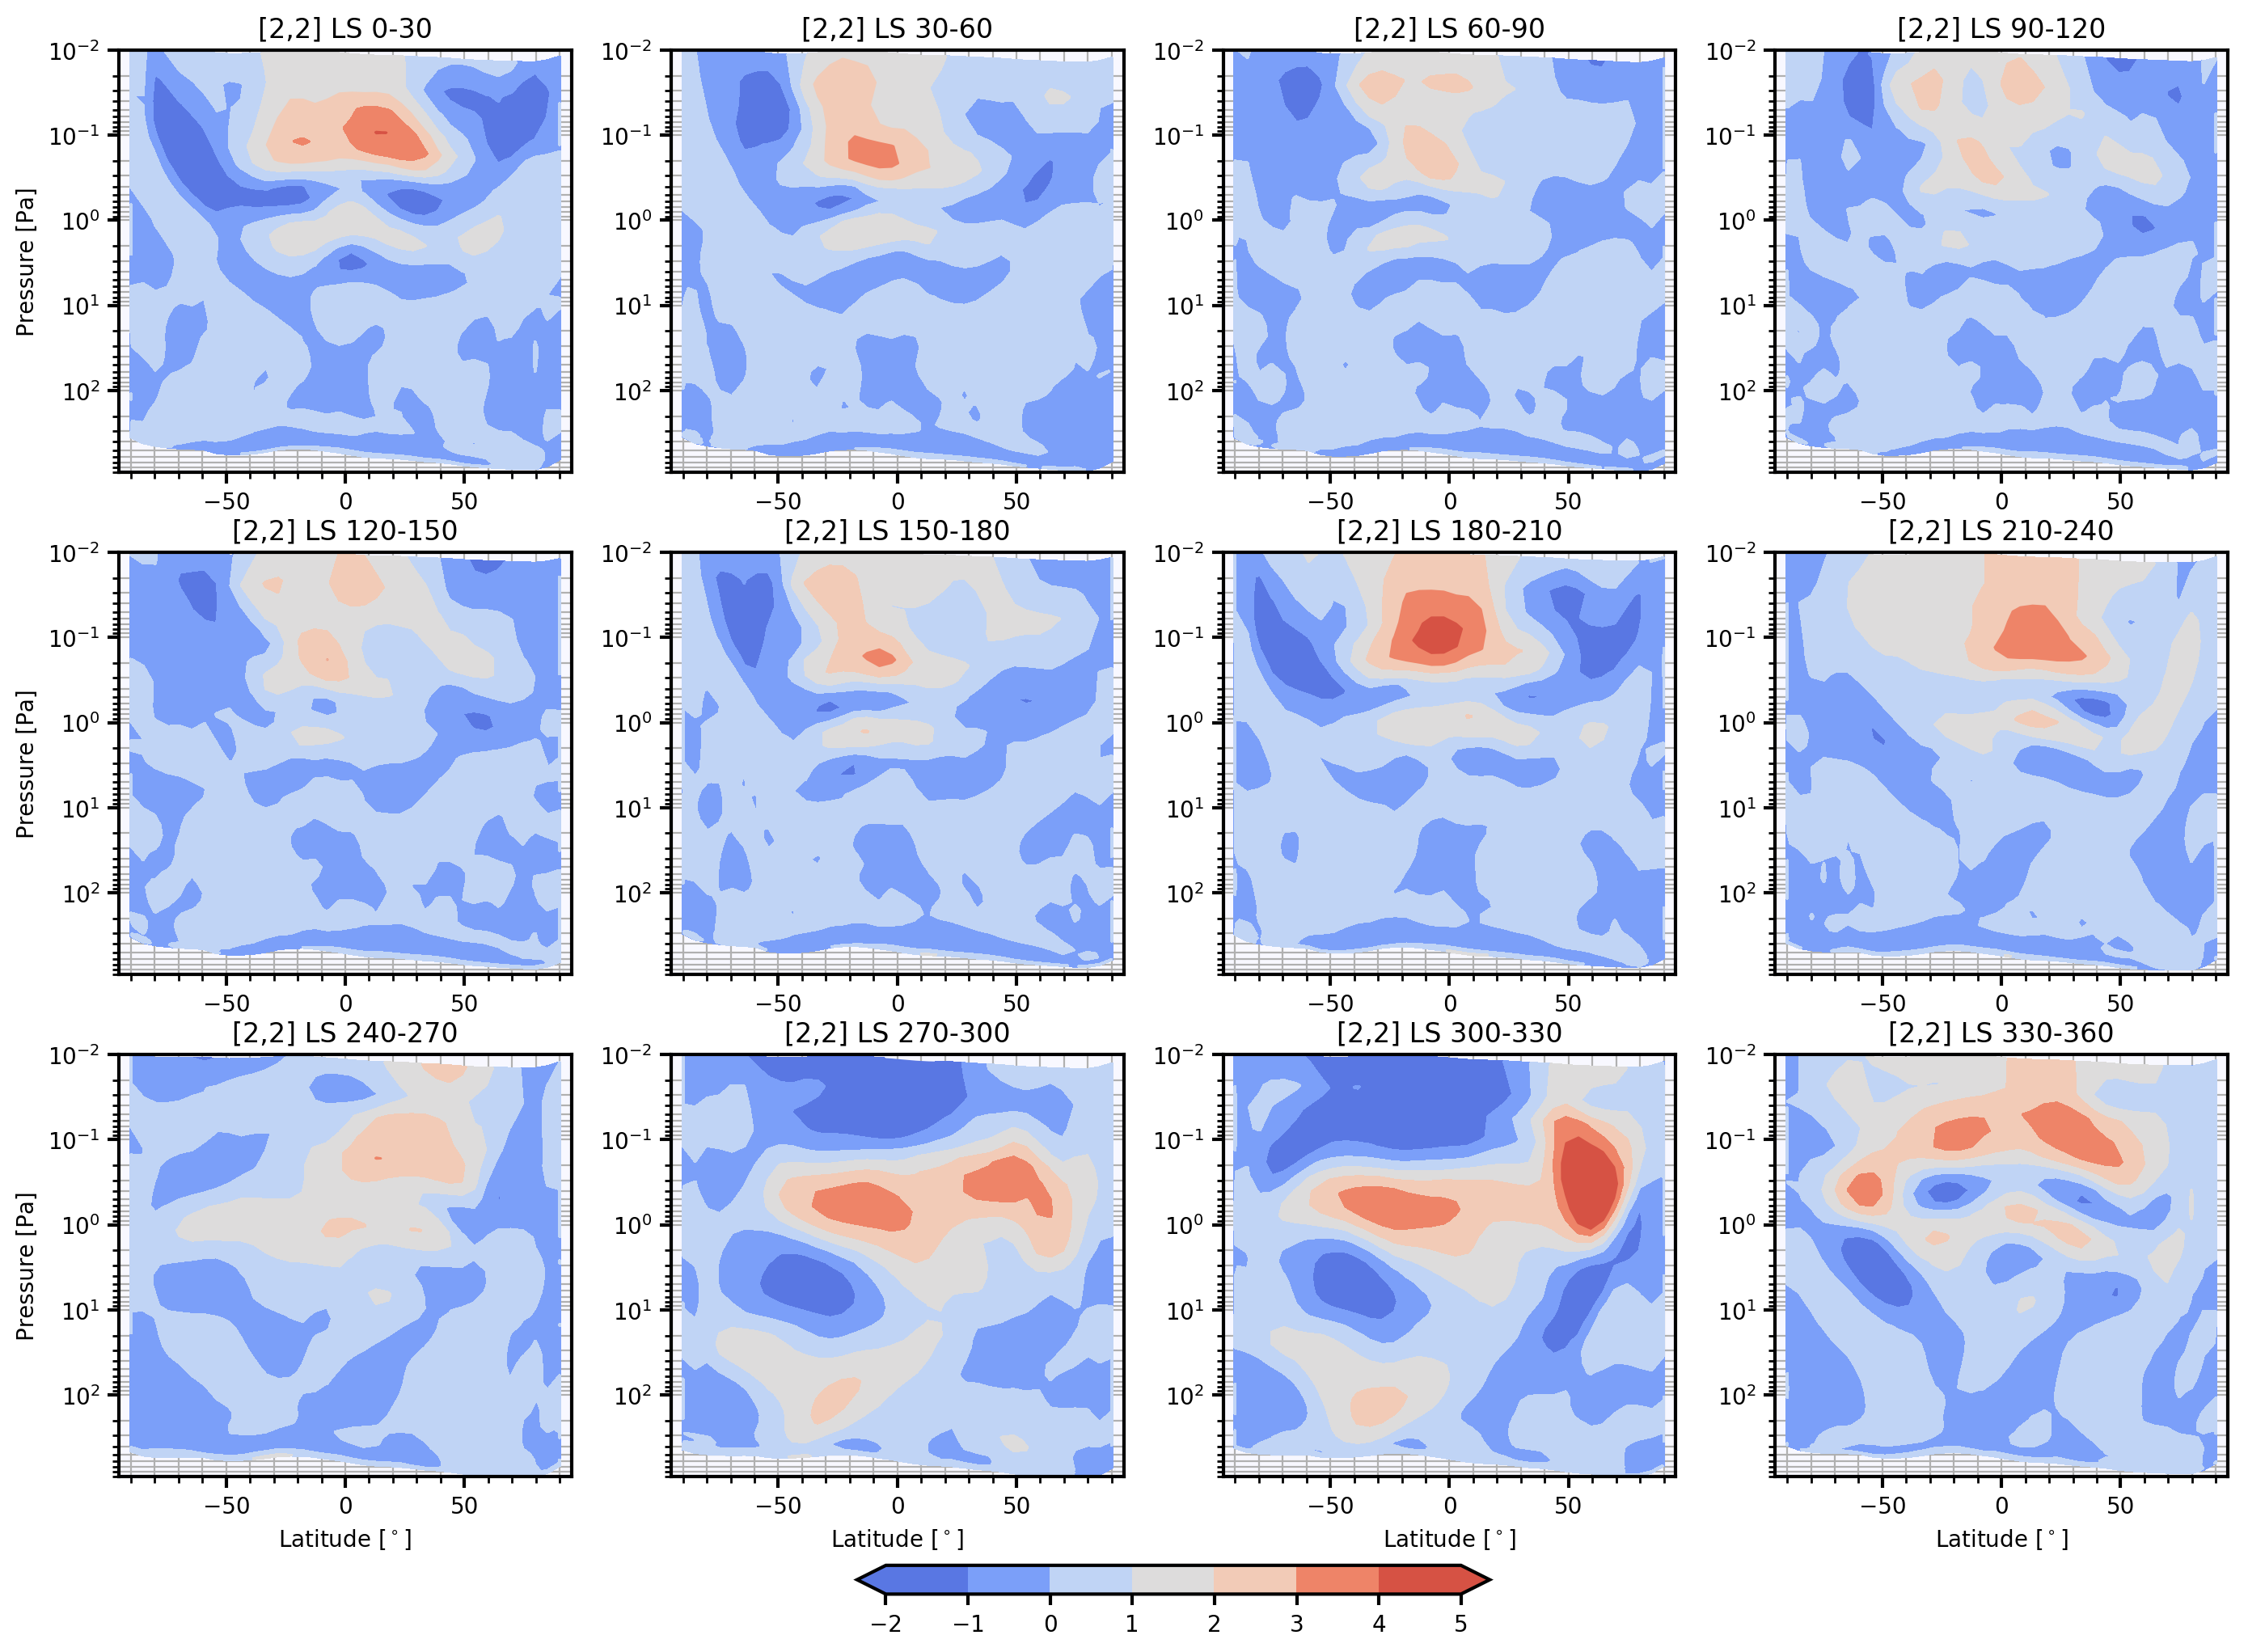

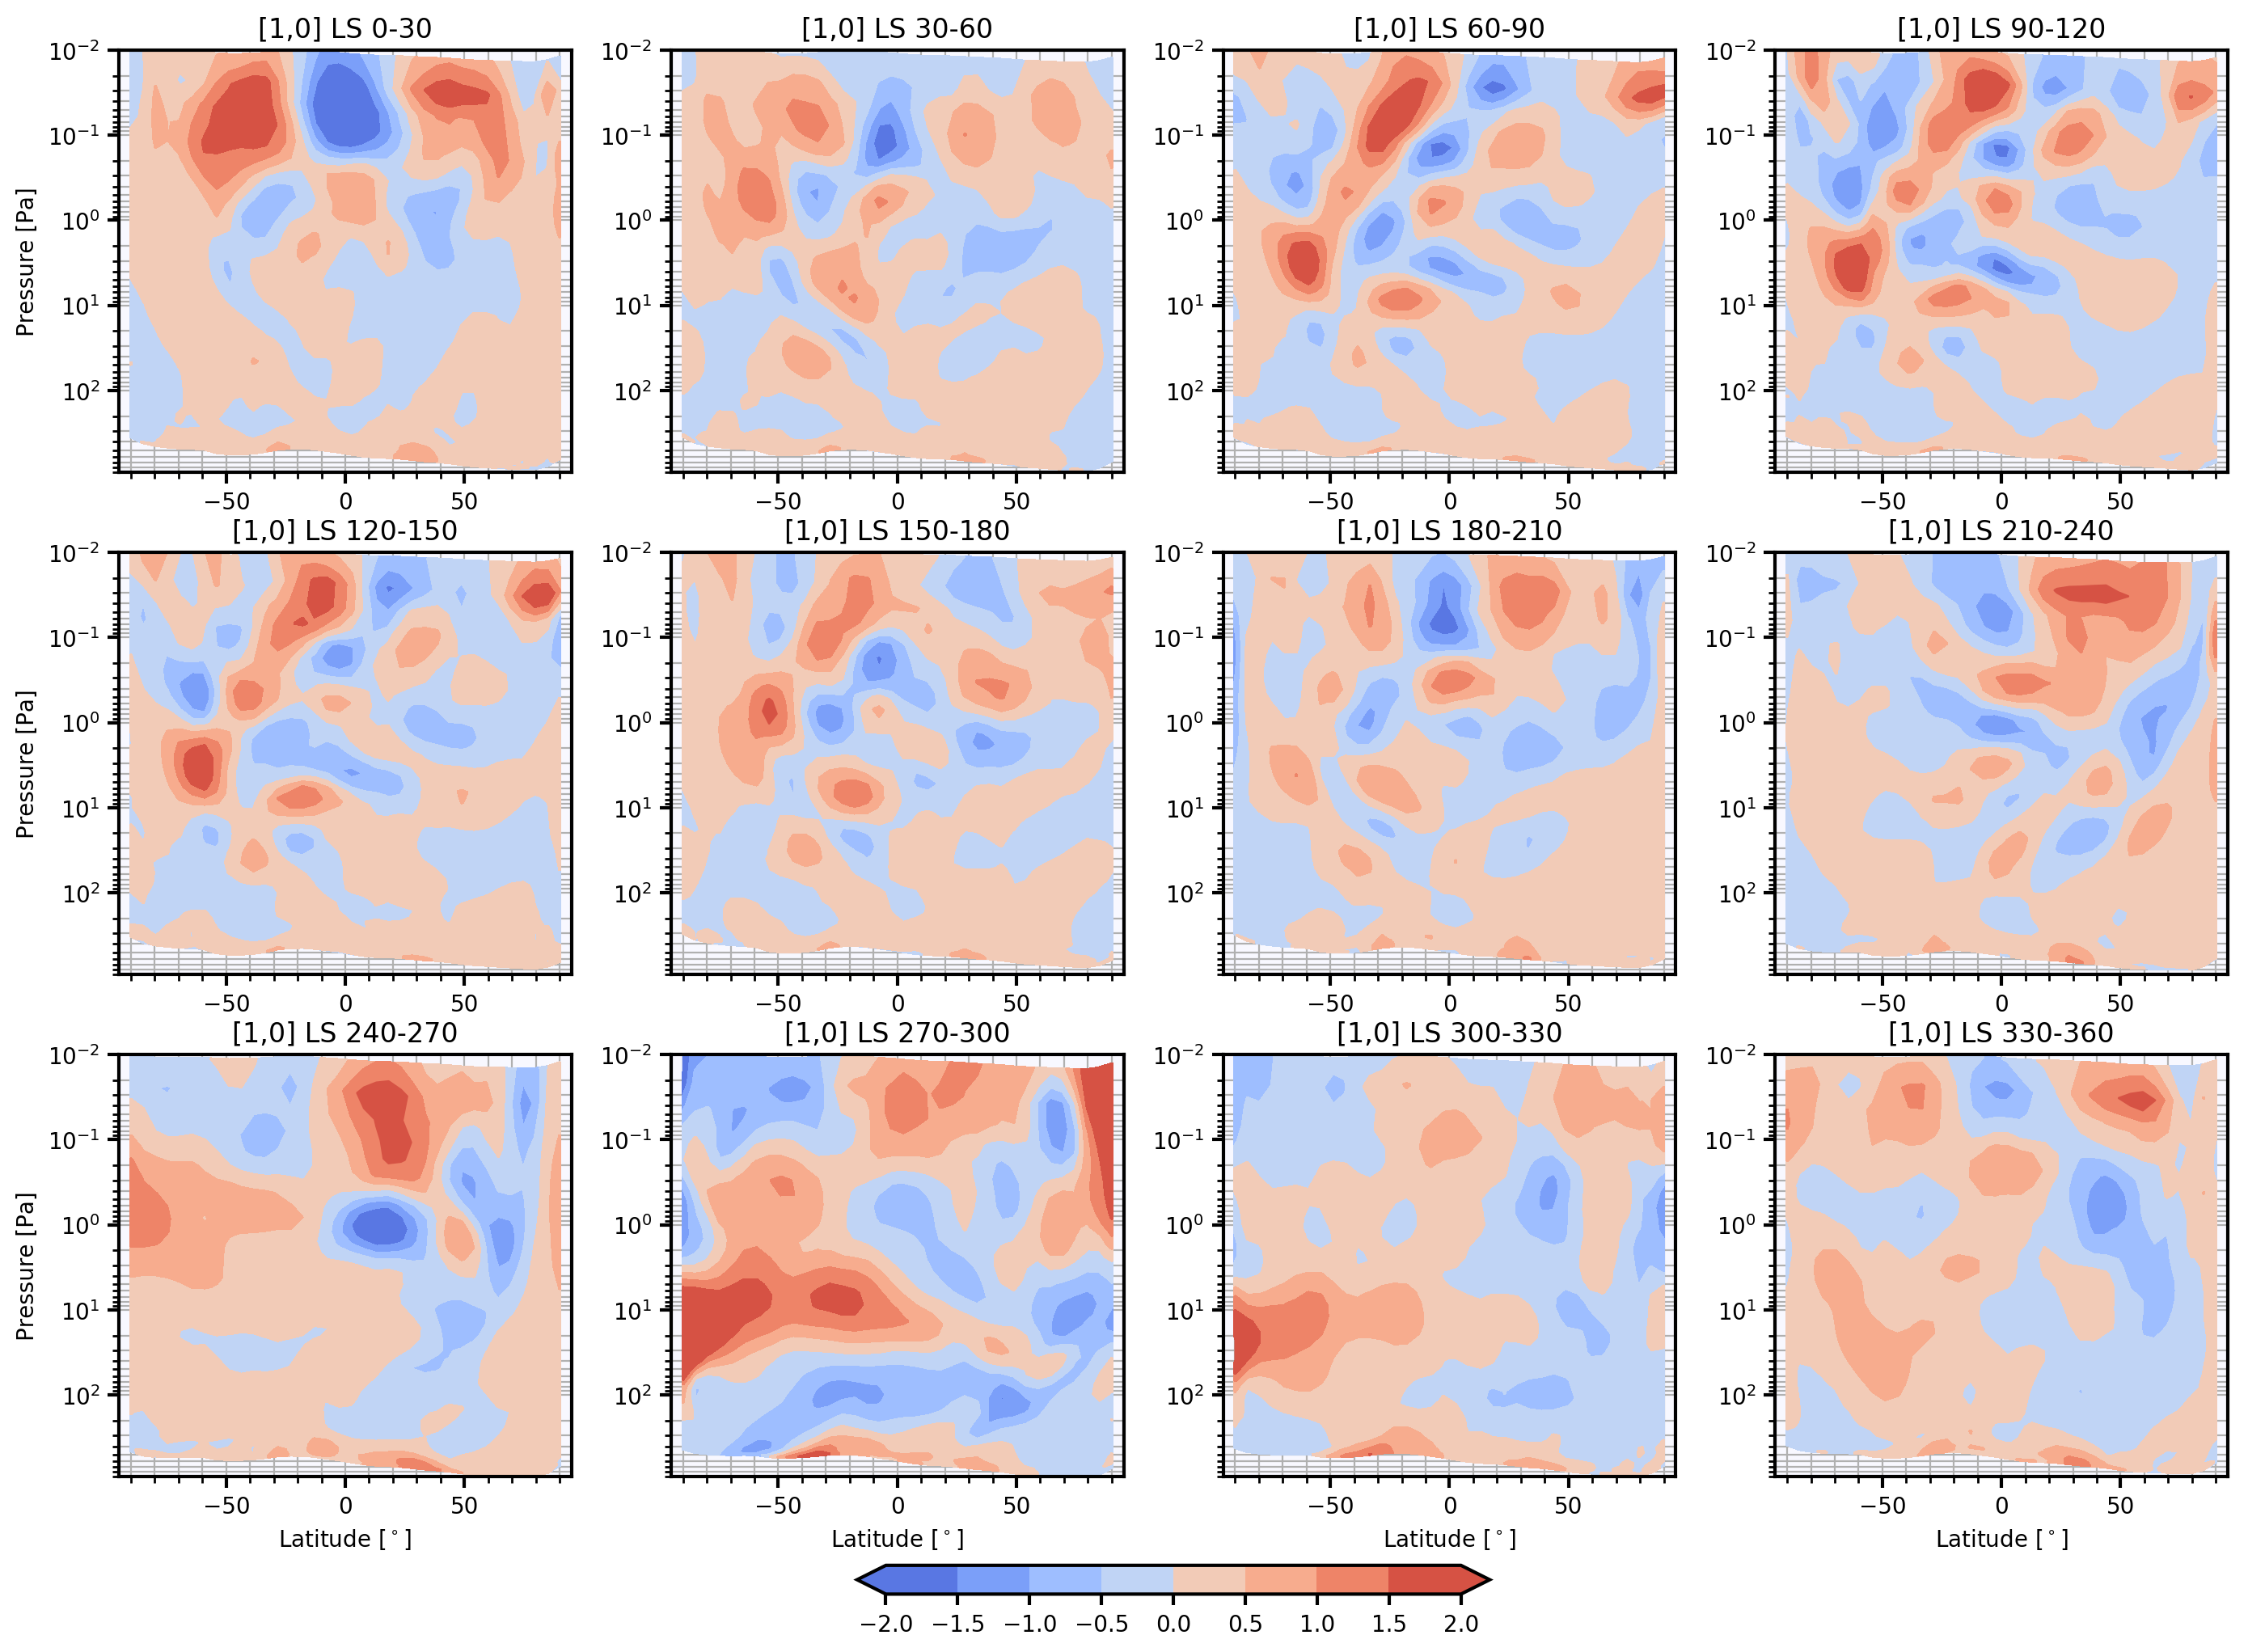

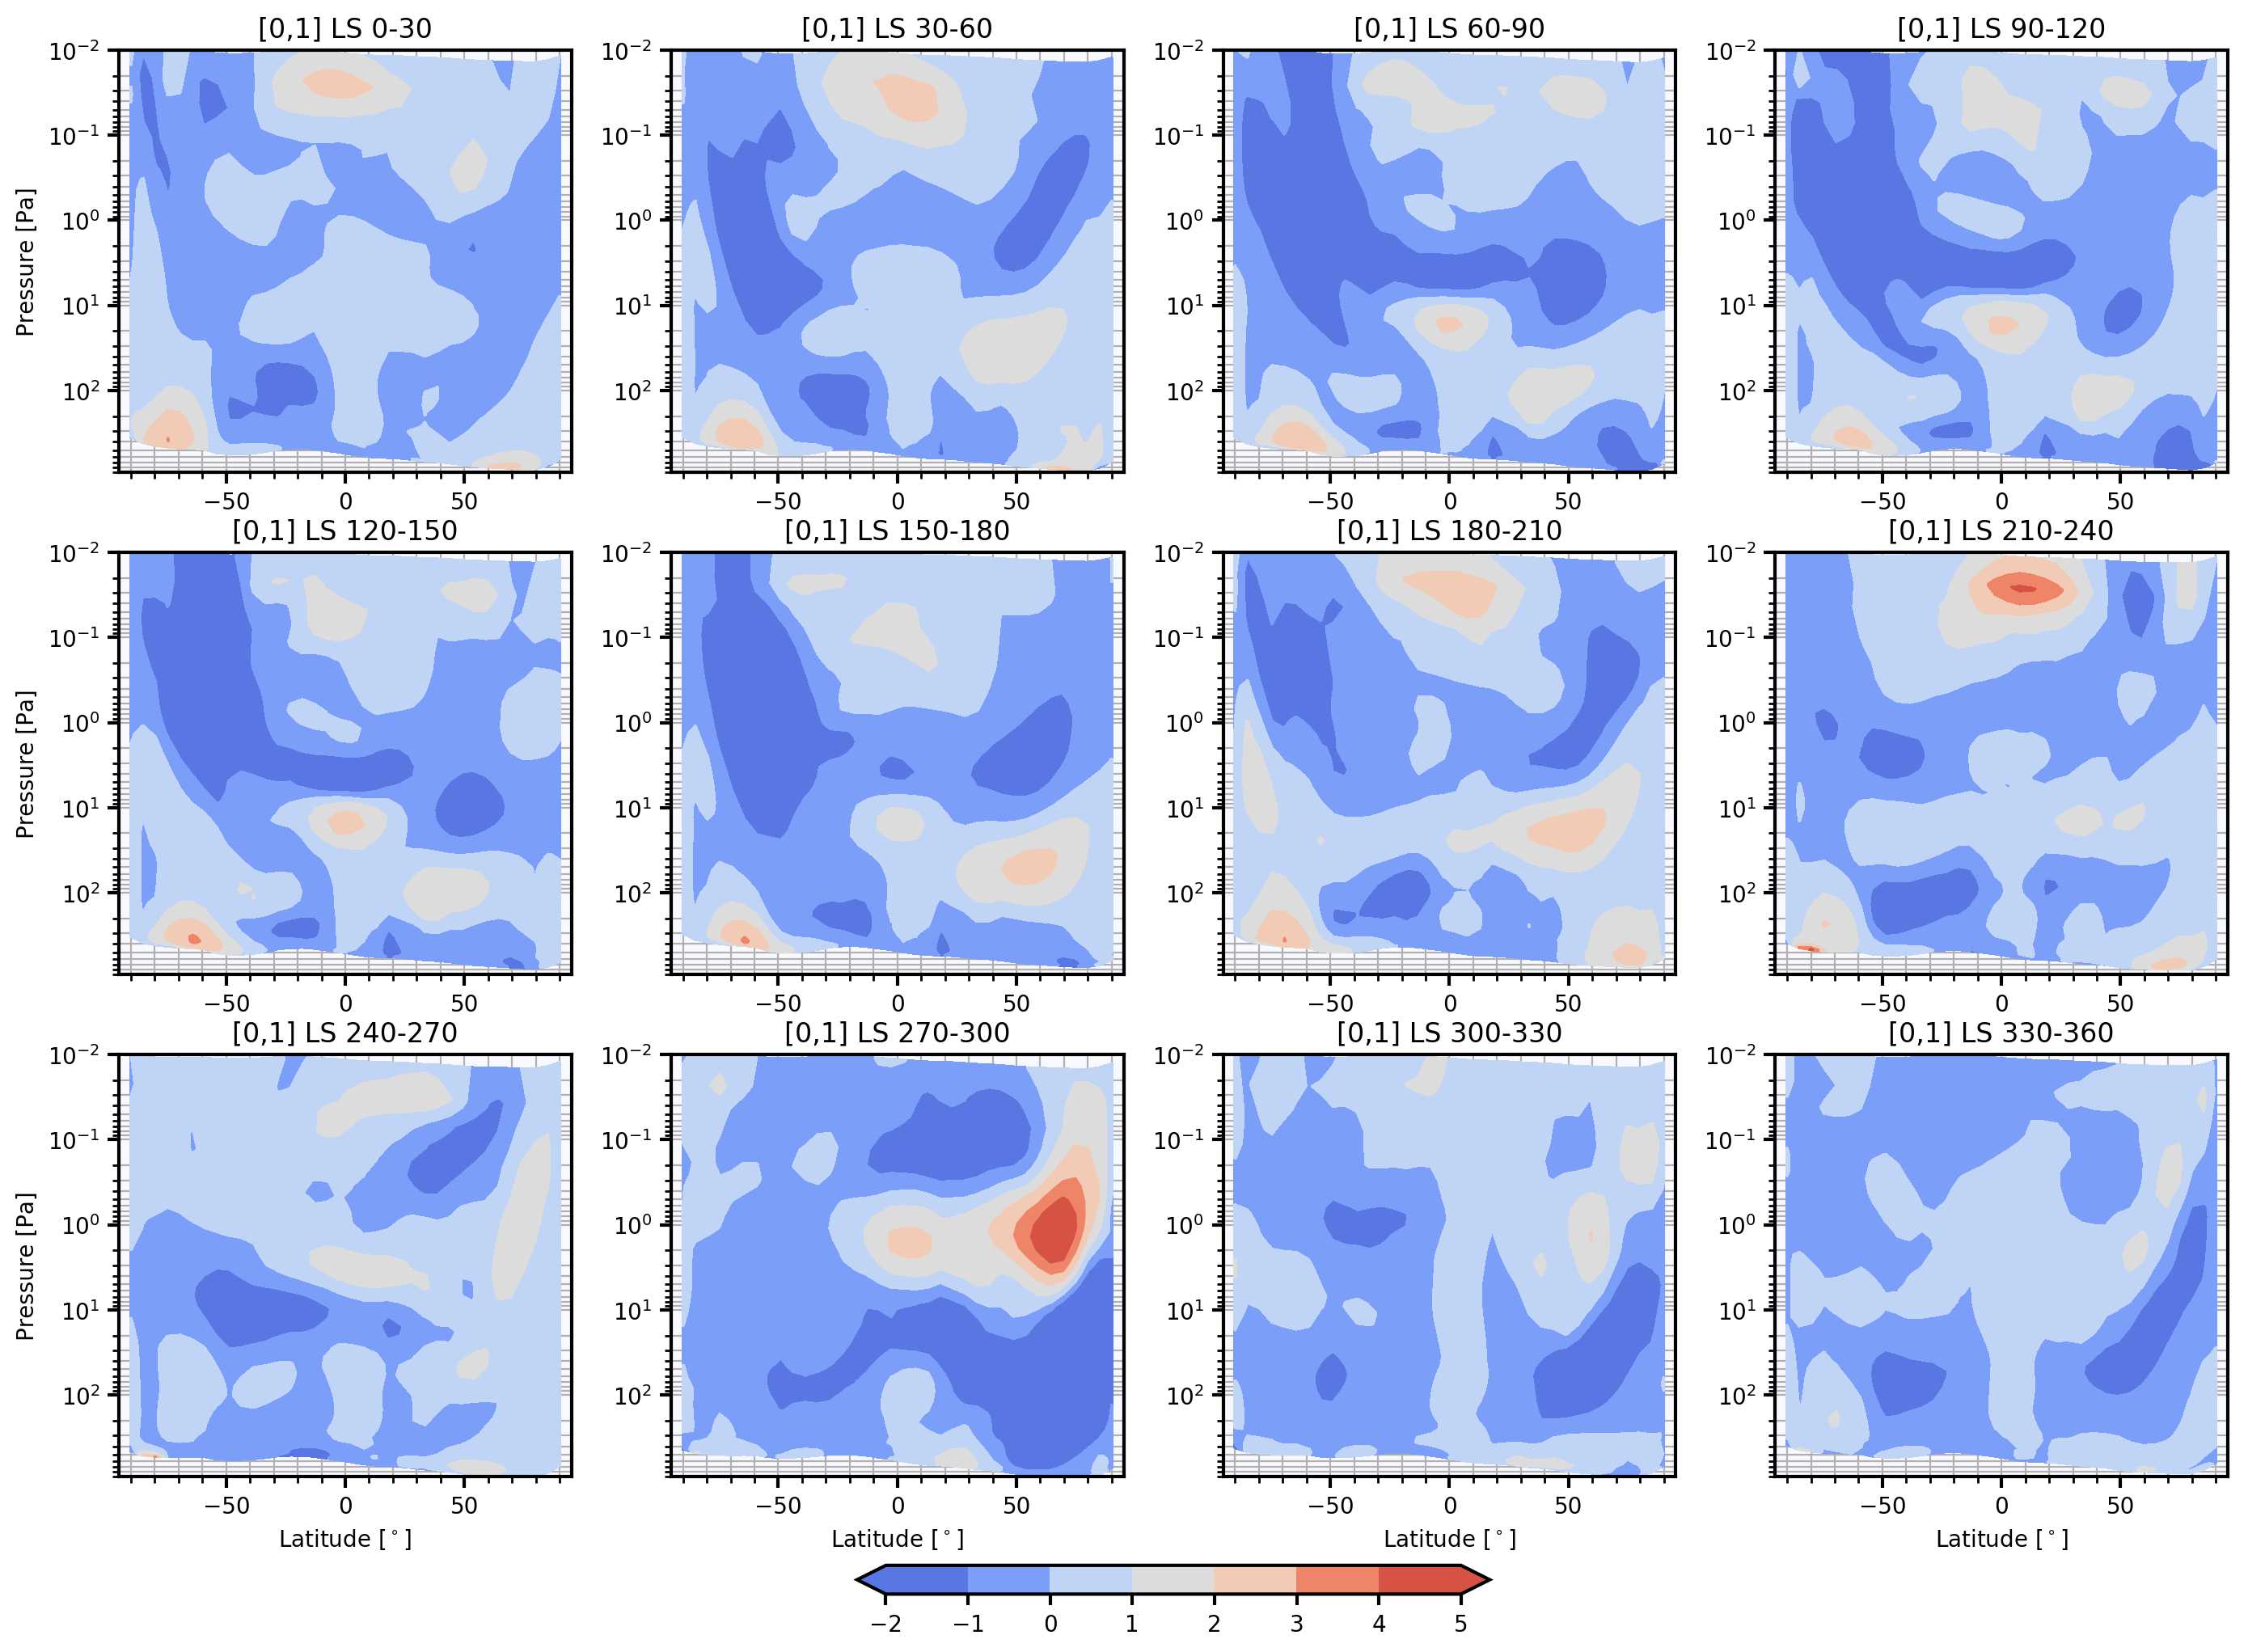

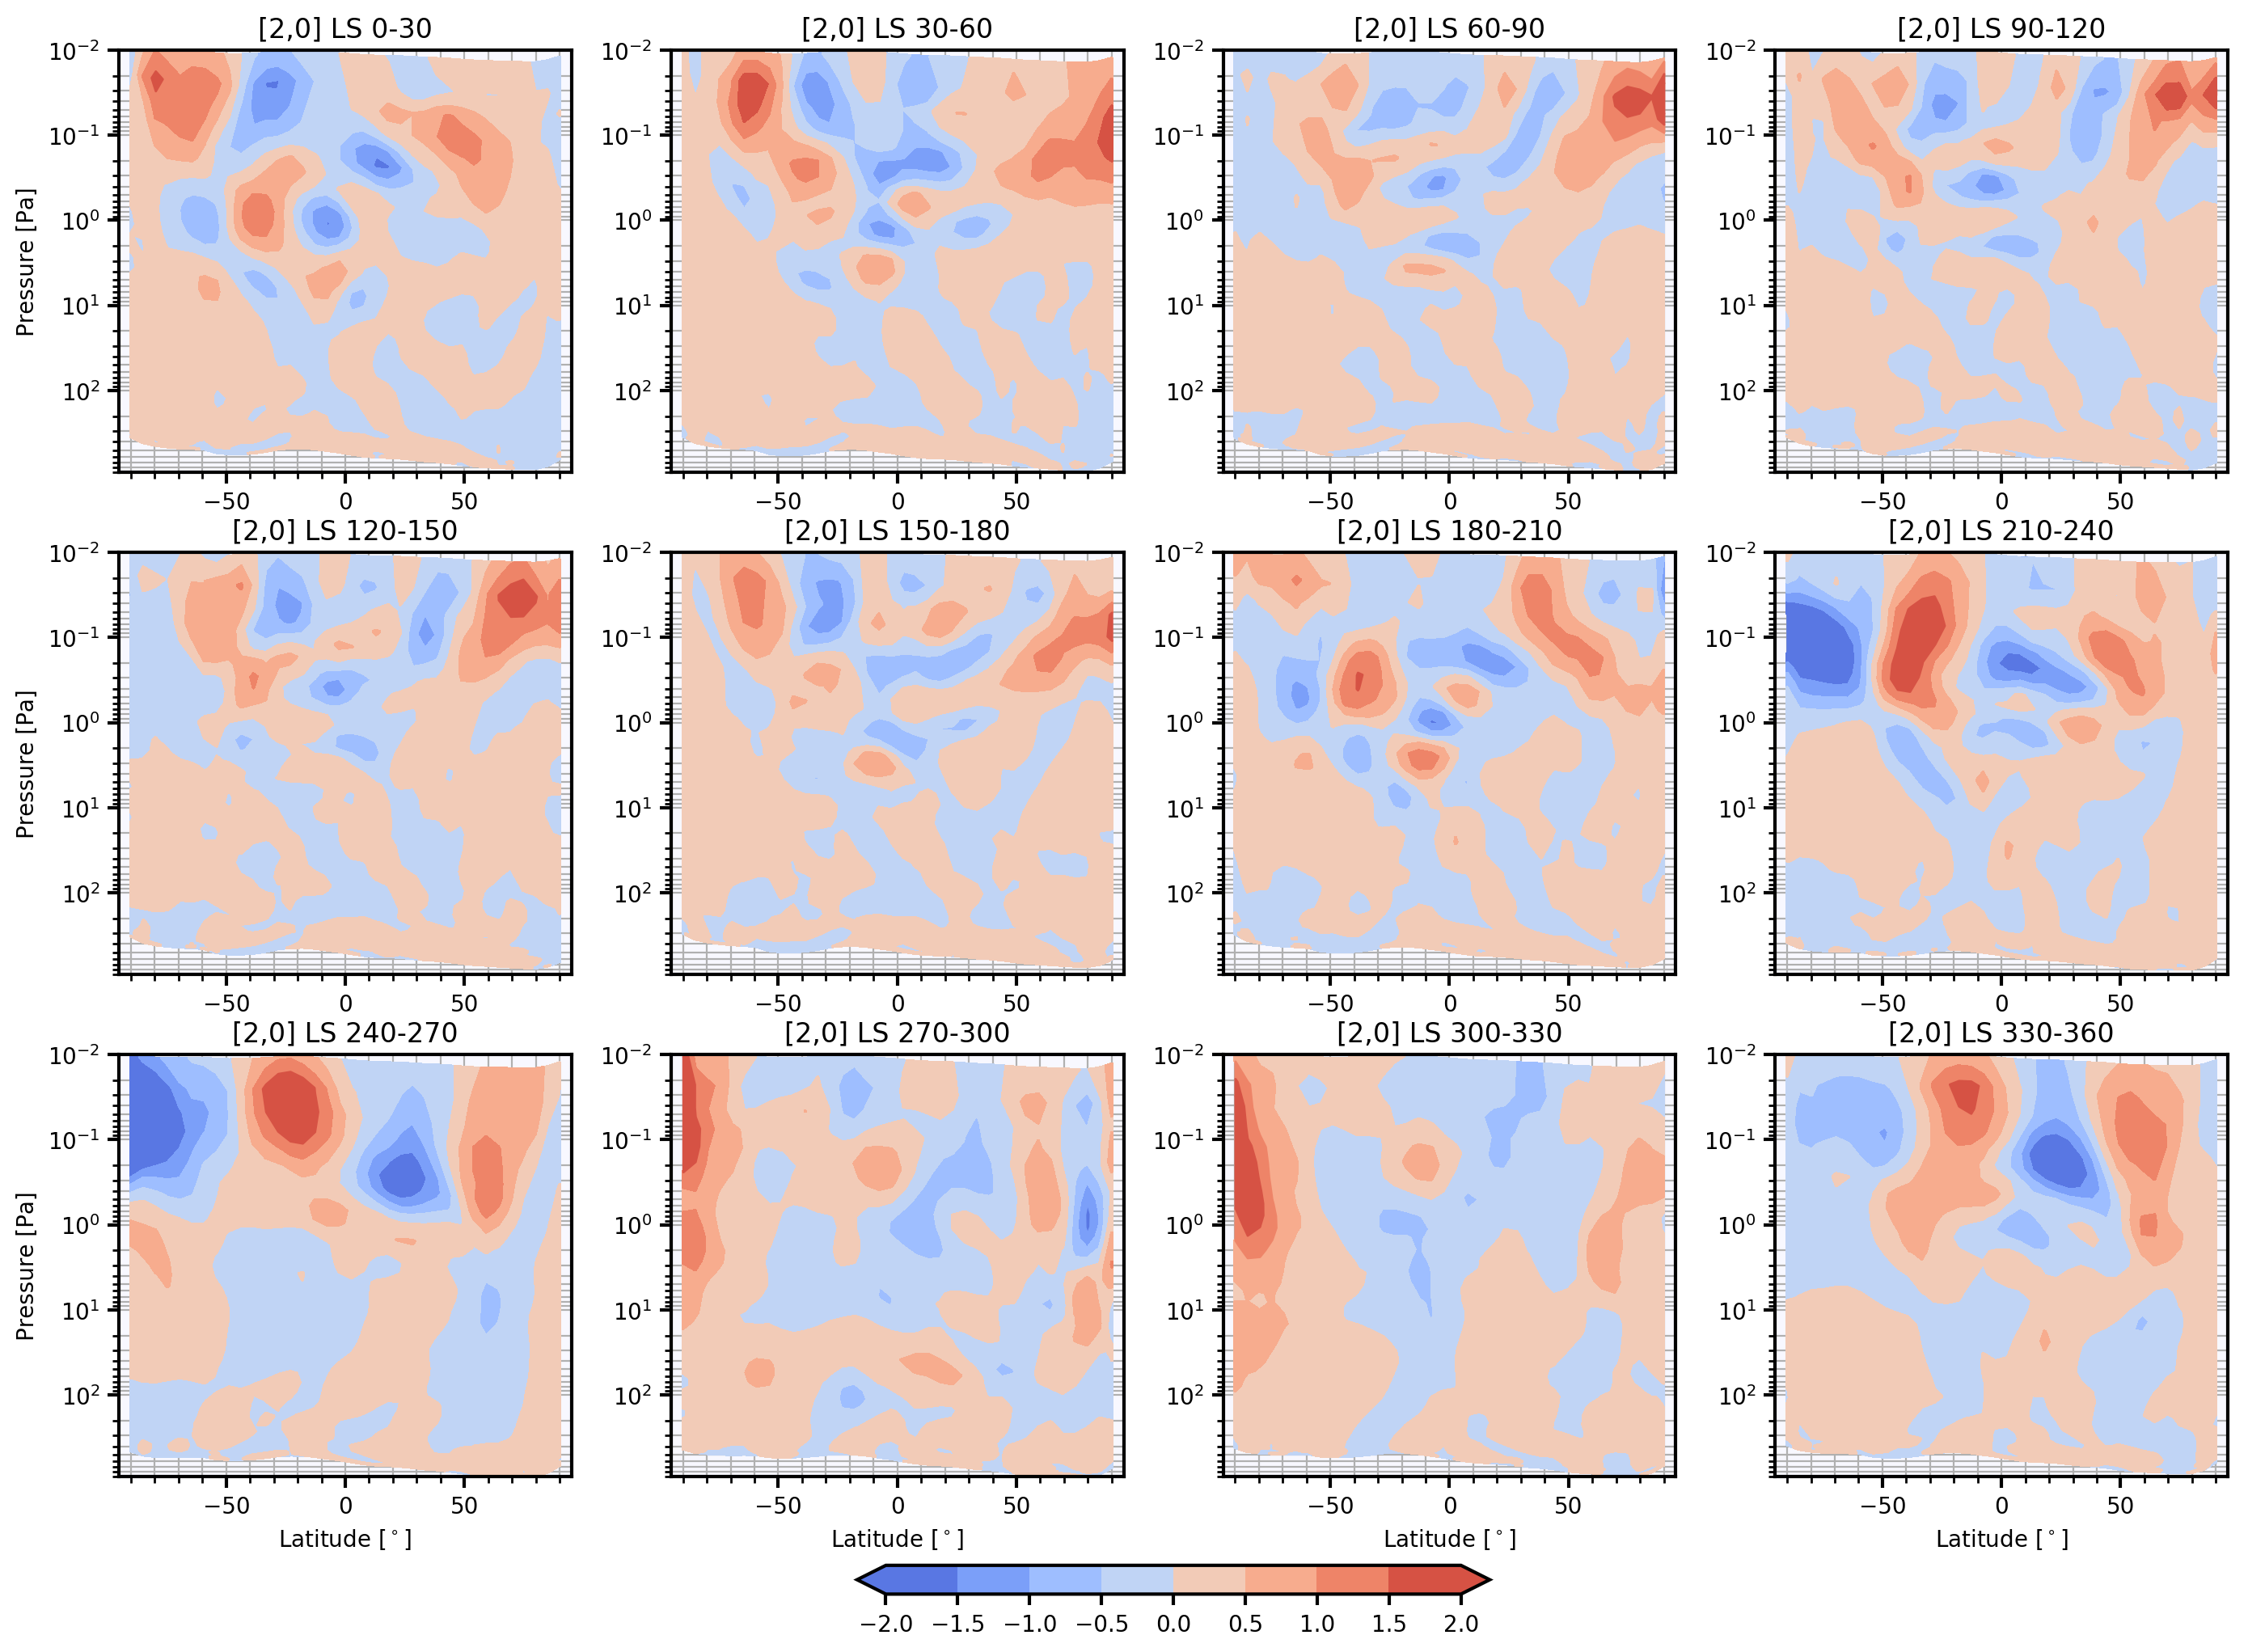

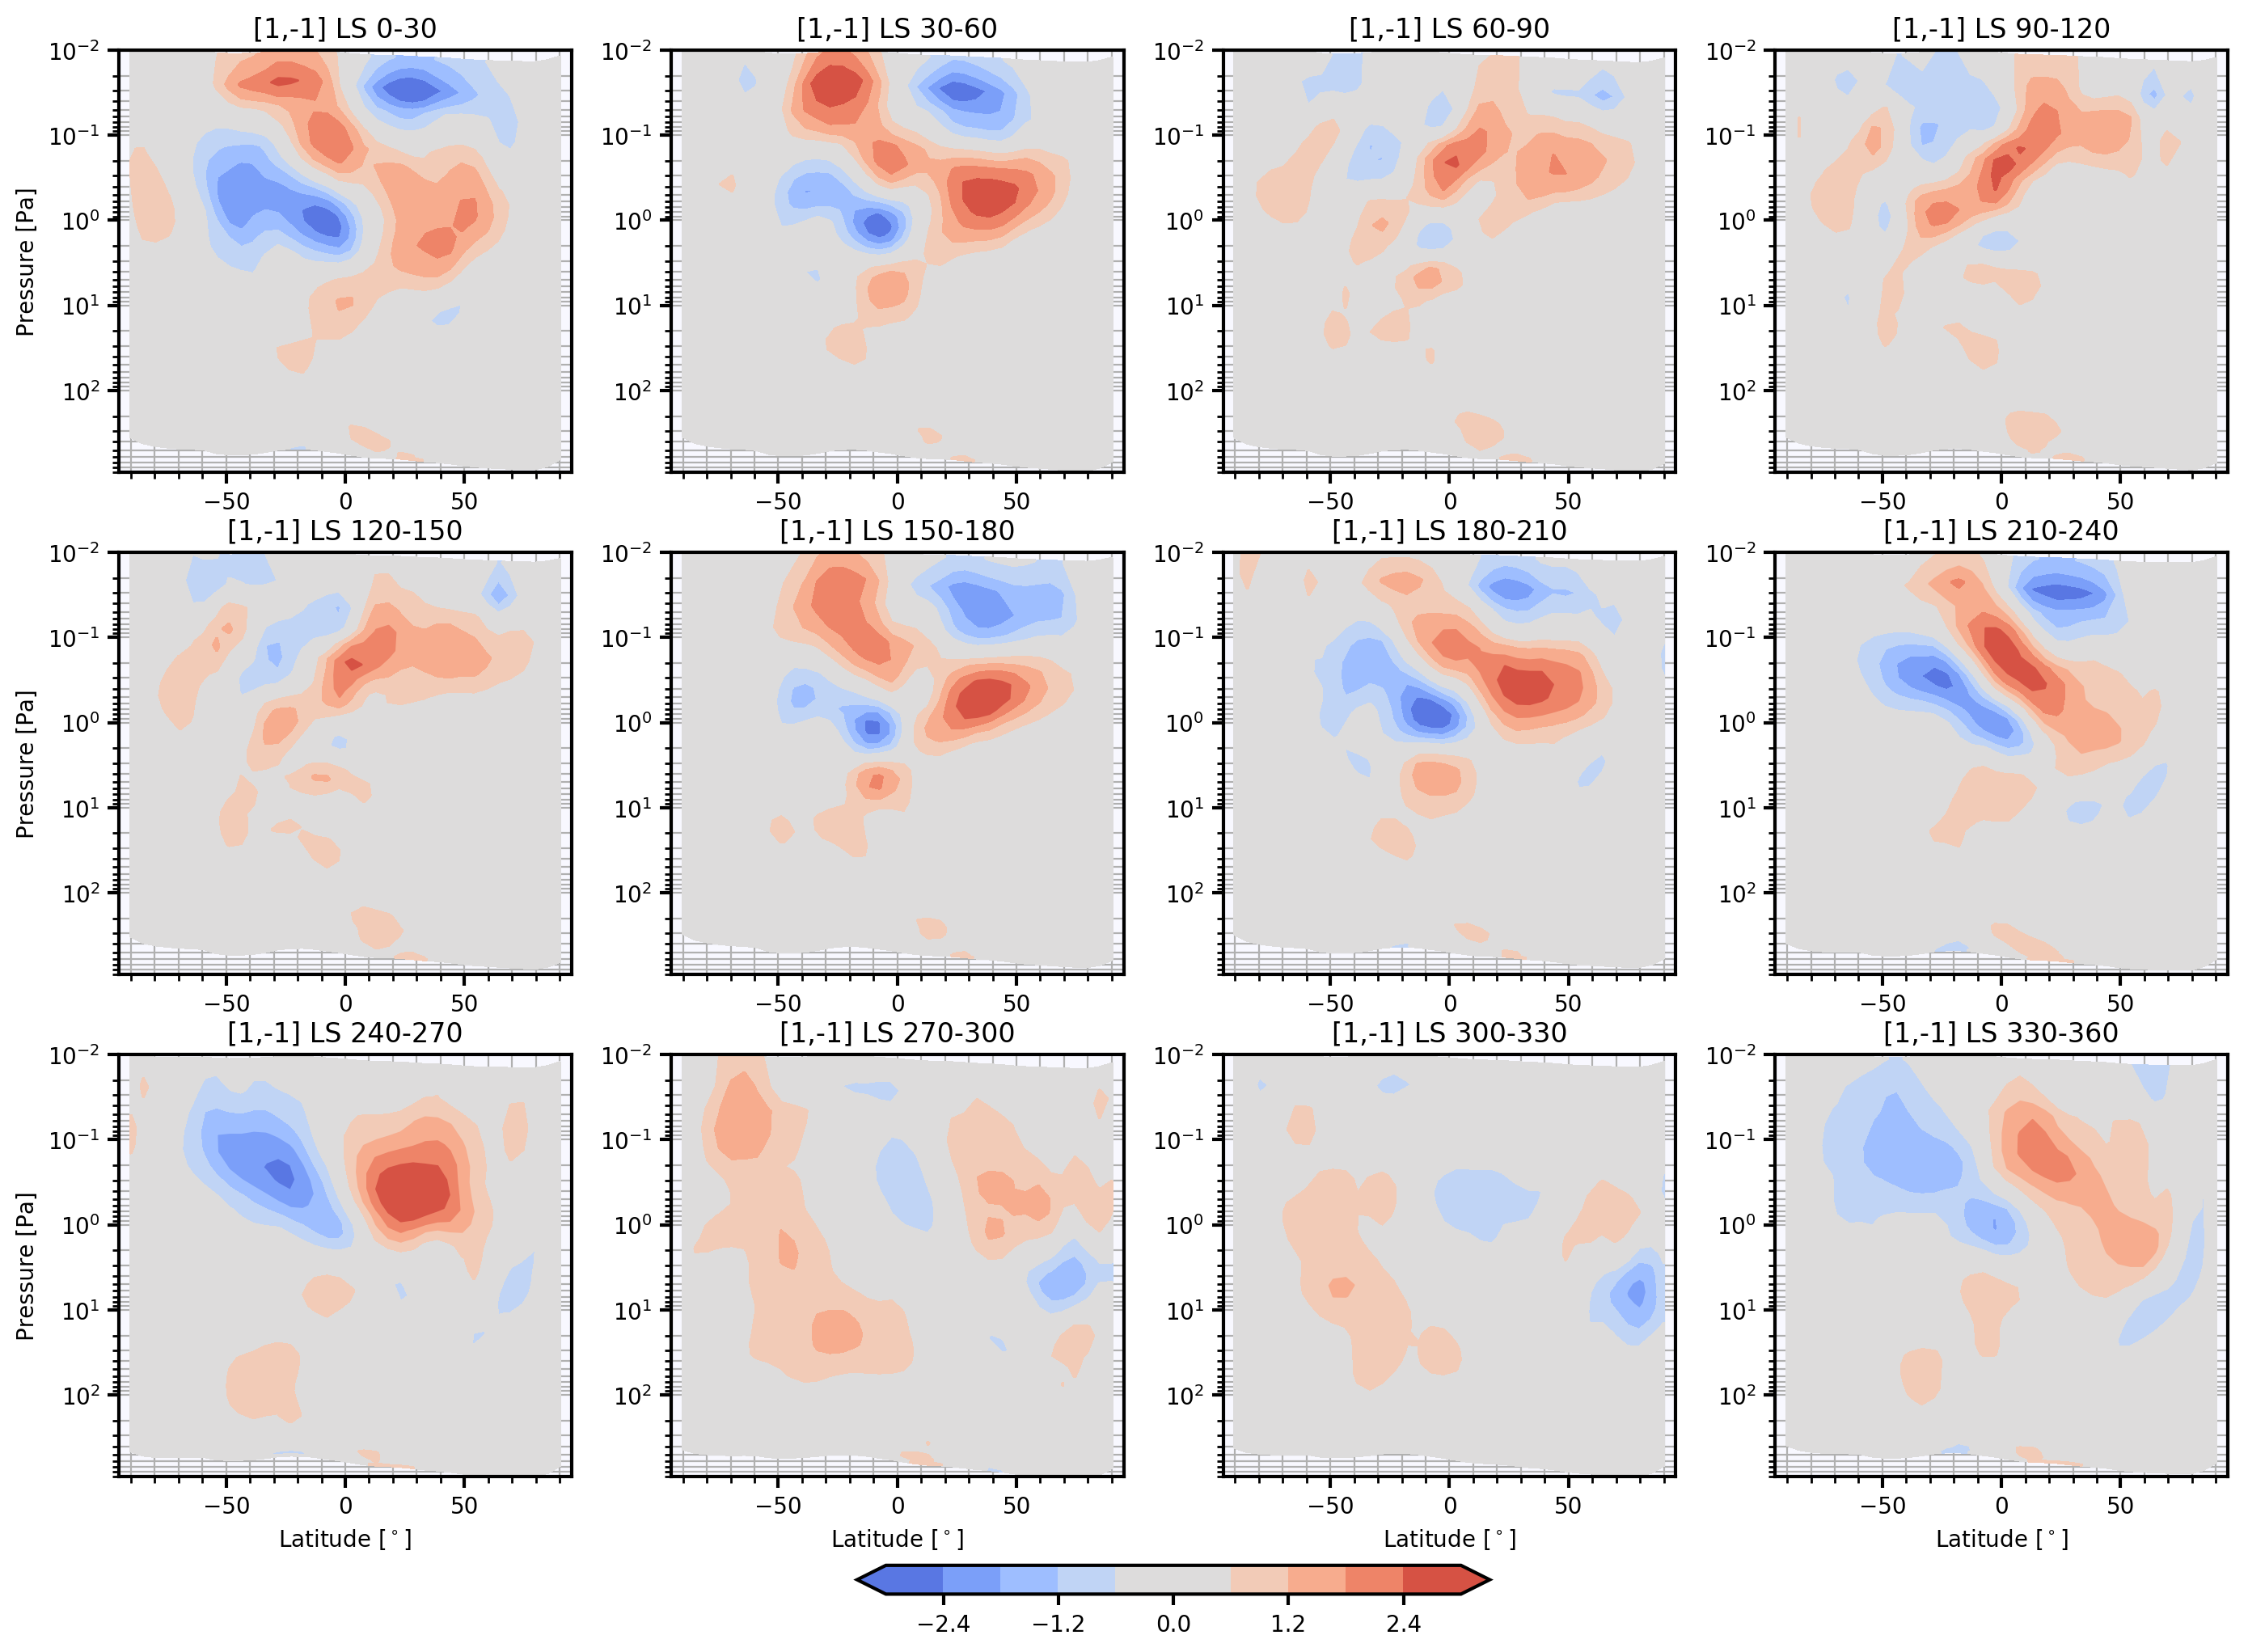

In [13]:
with PdfPages(dataname+'_wavenumber_modes.pdf') as pdFigures:
    zonal_plt_monthly(pressure, ls, M0_DIUR['real'], '[1,1]', np.linspace(-8,10, 10), False, cmap)
    zonal_plt_monthly(pressure, ls, M0_TER['real'], '[3,3]', np.linspace(-4,2,9), False, cmap)
    zonal_plt_monthly(pressure, ls, M0_ZM['real'], '[0,0]', np.linspace(110,240,14), False, cmap)
    zonal_plt_monthly(pressure, ls, M0_SEMI['real'], '[2,2]', np.linspace(-2,5,8), False, cmap)
    zonal_plt_monthly(pressure, ls, M1_10['real'], '[1,0]', np.linspace(-2,2,9), False, cmap)
    zonal_plt_monthly(pressure, ls, M1_01['real'], '[0,1]', np.linspace(-2,5,8), False, cmap)
    zonal_plt_monthly(pressure, ls, M2_20['real'], '[2,0]', np.linspace(-2,2,9), False, cmap)
    zonal_plt_monthly(pressure, ls, M2_1_1['real'], '[1,-1]', np.linspace(-3,3,11), False, cmap)

In [ ]:
from dwell import fft
a,p,x,y=fft.spec(tst,1./8,1./72,axes=[0,3])


In [ ]:
s=a*cos(p)
a1=a[abs(x+1)<0.1,:,:,y==1].mean(axis=0)
plt.contourf(lat, press, (a1))
plt.colorbar()
plt.yscale('log')
plt.ylim([900,1e-2])
figure()
plot(lat[40,:],a1[40,:]) ; title(press[40].mean())

In [ ]:
plt.contourf(lat, press, amp1+amp3)
plt.colorbar()
plt.yscale('log')
plt.ylim([900,1e-2])


In [88]:
#M0_DIUR['imag']
freq[165]
#contourf(tfull[0,165,:,:,37])
fa = filtered_array.reshape(8,12,52,36)

array([[ -6.82352126e-01,   3.08219218e+00,   5.68460226e+00, ...,
          2.75137480e-02,   1.19475648e-02,  -1.54493898e-02],
       [ -1.36031008e+00,   3.23640871e+00,   6.07713795e+00, ...,
          2.57837810e-02,   1.28223719e-02,  -9.89929214e-03],
       [ -1.64575636e+00,   3.32063794e+00,   5.91968250e+00, ...,
          1.86500363e-02,   1.00190584e-02,  -6.70690206e-05],
       ..., 
       [  1.39061809e-02,   4.39567059e-01,   1.06245649e+00, ...,
          2.86947131e+00,   1.20664680e+00,   4.33766961e-01],
       [ -2.86383480e-01,  -4.61636297e-02,   6.55337393e-01, ...,
          4.25267839e+00,   2.38741517e+00,   3.69435012e-01],
       [ -1.81338012e-01,   9.67224687e-02,   4.68965441e-01, ...,
          3.90097070e+00,   2.38156438e+00,   6.33918226e-01]], dtype=float32)

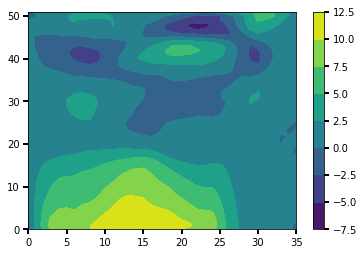

In [105]:
frequency, zwave#, fa.shape
#contourf(fa[1,10,:,:].imag+fa[3,10,:,:].imag)
contourf(M0_DIUR["imag"][10])
colorbar()
M0_DIUR['imag'].shape
M0_DIUR["imag"][10]

In [30]:
reset_selective data

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
